# EDA

In [187]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [188]:
# Import Module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import xgboost
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [189]:
# fixed random seed
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## Load Data

In [190]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')
building = pd.read_csv('./data/building_info.csv')

In [191]:
train.info()
train.shape
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


num_date_time  건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  일조(hr)  \
0  1_20220601 00     1  20220601 00   18.6      NaN      0.9   42.0     NaN   
1  1_20220601 01     1  20220601 01   18.0      NaN      1.1   45.0     NaN   
2  1_20220601 02     1  20220601 02   17.7      NaN      1.5   45.0     NaN   
3  1_20220601 03     1  20220601 03   16.7      NaN      1.4   48.0     NaN   
4  1_20220601 04     1  20220601 04   18.4      NaN      2.8   43.0     NaN   

   일사(MJ/m2)  전력소비량(kWh)  
0        NaN     1085.28  
1        NaN     1047.36  
2        NaN      974.88  
3        NaN      953.76  
4        NaN      986.40

In [192]:
building.info()
building.shape
building.건물유형.unique()
building.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    object 
 5   ESS저장용량(kWh)  100 non-null    object 
 6   PCS용량(kW)     100 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ KB


건물번호  건물유형    연면적(m2)   냉방면적(m2) 태양광용량(kW) ESS저장용량(kWh) PCS용량(kW)
0     1  건물기타  110634.00   39570.00         -            -         -
1     2  건물기타  122233.47   99000.00         -            -         -
2     3  건물기타  171243.00  113950.00        40            -         -
3     4  건물기타   74312.98   34419.62        60            -         -
4     5  건물기타  205884.00  150000.00         -         2557      1000

In [193]:
# 건물유형 값 영어로 변경
translation_dict = {
    '건물기타': 'Other Buildings',
    '공공': 'Public',
    '대학교': 'University',
    '데이터센터': 'Data Center',
    '백화점및아울렛': 'Department Store and Outlet',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    '지식산업센터': 'Knowledge Industry Center',
    '할인마트': 'Discount Mart',
    '호텔및리조트': 'Hotel and Resort'
}

building['건물유형'] = building['건물유형'].replace(translation_dict)

In [194]:
test.info()
test.shape
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  16800 non-null  object 
 1   건물번호           16800 non-null  int64  
 2   일시             16800 non-null  object 
 3   기온(C)          16800 non-null  float64
 4   강수량(mm)        16800 non-null  float64
 5   풍속(m/s)        16800 non-null  float64
 6   습도(%)          16800 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 918.9+ KB


num_date_time  건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)
0  1_20220825 00     1  20220825 00   23.5      0.0      2.2     72
1  1_20220825 01     1  20220825 01   23.0      0.0      0.9     72
2  1_20220825 02     1  20220825 02   22.7      0.0      1.5     75
3  1_20220825 03     1  20220825 03   22.1      0.0      1.3     78
4  1_20220825 04     1  20220825 04   21.8      0.0      1.0     77

## Data Preprocessing

In [195]:
print(len(train[(train['강수량(mm)'] != 0) & (train['강수량(mm)'].notnull())])/len(train))
print(len(test[(test['강수량(mm)'] != 0)])/len(test))

0.12171568627450981
0.15767857142857142


- 총 100개의 건물
- train : 각 건물 당 2040개의 데이터, test : 각 건물 당 168개의 데이터
- 태양광용량, ESS, PCS의 경우 - 값으로 표기되어 있는데 이것은 해당 장비가 설치되어 있지 않은 건물을 의미하므로 0으로 대체
- test에서 강수량이 0이 아닌 데이터의 비율이 약 15.8% (test는 결측치 없음)
- train에서 강수량이 0이 아니고, 결측치도 아닌 데이터의 비율이 약 12.2%
- 따라서 train의 결측치를 임의의 값으로 채우는 것 보다는 0으로 채우는 것이 더 적합할 것으로 보임
- 일조, 일사의 경우도 위와 같이 확인해볼수도 있으나 test dataset에 애초에 존재하지 않으므로 제거
- num_date_time의 경우 건물번호와 일시를 단순히 합친 것이므로 제거
- 풍속과 습도의 경우 이전 시점과 다음 시점의 값과 밀접한 관련이 있을 것이므로 이전 시점의 값과 다음 시점의 값의 평균으로 결측치를 채워넣음

In [196]:
# Merge data
# 건물번호를 기준으로 train, test data와 building data merge
train_df = train.copy()
test_df = test.copy()

train_df = pd.merge(train_df, building, on='건물번호')
test_df = pd.merge(test_df, building, on='건물번호')

display(train_df.head())
display(test_df.head())

num_date_time  건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  일조(hr)  \
0  1_20220601 00     1  20220601 00   18.6      NaN      0.9   42.0     NaN   
1  1_20220601 01     1  20220601 01   18.0      NaN      1.1   45.0     NaN   
2  1_20220601 02     1  20220601 02   17.7      NaN      1.5   45.0     NaN   
3  1_20220601 03     1  20220601 03   16.7      NaN      1.4   48.0     NaN   
4  1_20220601 04     1  20220601 04   18.4      NaN      2.8   43.0     NaN   

   일사(MJ/m2)  전력소비량(kWh)             건물유형   연면적(m2)  냉방면적(m2) 태양광용량(kW)  \
0        NaN     1085.28  Other Buildings  110634.0   39570.0         -   
1        NaN     1047.36  Other Buildings  110634.0   39570.0         -   
2        NaN      974.88  Other Buildings  110634.0   39570.0         -   
3        NaN      953.76  Other Buildings  110634.0   39570.0         -   
4        NaN      986.40  Other Buildings  110634.0   39570.0         -   

  ESS저장용량(kWh) PCS용량(kW)  
0            -         -  
1            -         -  
2            -         -  
3            -         -  
4            -         -

num_date_time  건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  \
0  1_20220825 00     1  20220825 00   23.5      0.0      2.2     72   
1  1_20220825 01     1  20220825 01   23.0      0.0      0.9     72   
2  1_20220825 02     1  20220825 02   22.7      0.0      1.5     75   
3  1_20220825 03     1  20220825 03   22.1      0.0      1.3     78   
4  1_20220825 04     1  20220825 04   21.8      0.0      1.0     77   

              건물유형   연면적(m2)  냉방면적(m2) 태양광용량(kW) ESS저장용량(kWh) PCS용량(kW)  
0  Other Buildings  110634.0   39570.0         -            -         -  
1  Other Buildings  110634.0   39570.0         -            -         -  
2  Other Buildings  110634.0   39570.0         -            -         -  
3  Other Buildings  110634.0   39570.0         -            -         -  
4  Other Buildings  110634.0   39570.0         -            -         -

In [197]:
# 태양광용량, ESS, PCS의 unique값 확인
for i in train_df['건물번호'].unique():
    print(train_df[train_df['건물번호'] == i]['태양광용량(kW)'].unique())
    print(train_df[train_df['건물번호'] == i]['ESS저장용량(kWh)'].unique())
    print(train_df[train_df['건물번호'] == i]['PCS용량(kW)'].unique(), '\n')

# 확인 결과 각 건물 당 unique한 값이 2개가 있는 경우는 없음
# pcs가 애초에 ess에 적용되는 장치이므로 둘 중 하나만 있는 경우는 없음

['-']
['-']
['-'] 

['-']
['-']
['-'] 

['40']
['-']
['-'] 

['60']
['-']
['-'] 

['-']
['2557']
['1000'] 

['-']
['-']
['-'] 

['-']
['800']
['300'] 

['-']
['-']
['-'] 

['-']
['-']
['-'] 

['-']
['-']
['-'] 

['447.2']
['-']
['-'] 

['130.6']
['-']
['-'] 

['-']


['-']
['-'] 

['56']
['-']
['-'] 

['-']
['-']
['-'] 

['20']
['-']
['-'] 

['-']
['-']
['-'] 

['64.8']
['-']
['-'] 

['-']
['1362']
['500'] 

['-']
['-']
['-'] 

['70']
['837.1']
['500'] 

['110']
['-']
['-'] 

['-']
['-']
['-'] 

['97.65']
['-']
['-'] 

['50']
['-']
['-'] 

['26.64']
['-']
['-'] 

['30']
['-']
['-'] 

['50']
['-']
['-'] 

['25']
['-']
['-'] 

['20']
['-']
['-'] 

['83.72']
['-']
['-'] 

['-']
['-']
['-'] 

['-']
['-']
['-'] 

['-']
['-']
['-'] 

['-']
['-']
['-'] 

['-']
['-']
['-'] 

['35']
['-']
['-'] 

['-']
['-']
['-'] 

['-']
['-']
['-'] 

['-']
['-']
['-'] 

['-']
['-']
['-'] 

['-']
['-']
['-'] 

['-']
['-']
['-'] 

['-']
['-']
['-'] 

['-']
['-']
['-'] 

['100.56']
['-']
['-'] 

['-']
['-']
['-'] 

['200']
['-']
['-'] 

['46.2']
['-']
['-'] 

['3']
['-']
['-'] 

['-']
['-']
['-'] 

['25']
['-']
['-'] 

['-']
['-']
['-'] 

['-']
['-']
['-'] 

['-']
['-']
['-'] 

['-']
['-']
['-'] 

['200']
['-']
['-'] 

['9.45']
['-']
['-'] 

['-']
['-']
['-'] 

['365']
['-']

In [198]:
# Drop the unnecessary columns for analysis
train_df.drop(columns=['num_date_time', '일조(hr)', '일사(MJ/m2)'], inplace=True)
test_df.drop(columns=['num_date_time'], inplace=True)

In [199]:
# Process the missing values of precipitation
train_df['강수량(mm)'].fillna(0, inplace=True) # 강수량은 0으로 채움

In [200]:
# Process the missing values of solar, ESS, PCS
# -을 0으로 대체
train_df[['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']] = train_df[['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']].replace('-', 0)
train_df[['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']] = train_df[['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']].astype(float)

In [201]:
train_df[train_df['풍속(m/s)'].isnull()]

건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  전력소비량(kWh)  \
16643      9  20220614 11   17.6      0.0      NaN    NaN     2330.40   
30161     15  20220806 17   35.6      0.0      NaN    NaN     1815.57   
32127     16  20220803 15   30.4      0.0      NaN   77.0     5062.08   
51640     26  20220627 16   27.2      3.1      NaN   93.0     5330.40   
51921     26  20220709 09   26.3      0.0      NaN   84.0     2908.80   
84418     42  20220703 10   29.8      0.0      NaN   66.0     3038.76   
100738    50  20220703 10   29.8      0.0      NaN   66.0     3044.70   
105639    52  20220806 15   33.4      0.0      NaN   72.0     2260.20   
105640    52  20220806 16   33.5      0.0      NaN   73.0     2274.30   
176477    87  20220714 05   21.9      0.0      NaN    NaN      519.66   
176478    87  20220714 06   22.3      0.0      NaN    NaN      632.88   
176479    87  20220714 07   22.8      0.0      NaN    NaN      738.72   
176480    87  20220714 08   23.3      0.0      NaN    NaN     1547.28   
176481    87  20220714 09   23.8      0.0      NaN    NaN     2059.74   
183161    90  20220806 17   35.6      0.0      NaN    NaN     2504.16   
197439    97  20220806 15   33.4      0.0      NaN   72.0     2021.04   
197440    97  20220806 16   33.5      0.0      NaN   73.0     1994.58   
202143   100  20220608 15   24.9      0.0      NaN    NaN      880.32   
203211   100  20220723 03   20.3      0.0      NaN   99.0      338.16   

                               건물유형    연면적(m2)   냉방면적(m2)  태양광용량(kW)  \
16643               Other Buildings  222882.35   15651.18       0.00   
30161               Other Buildings  167012.31  167012.31       0.00   
32127                        Public  240038.00   95175.00      20.00   
51640                    University  386466.90  162020.00      26.64   
51921                    University  386466.90  162020.00      26.64   
84418   Department Store and Outlet   97915.10   72000.00       0.00   
100738                     Hospital   91967.00   75836.00       3.00   
105639                     Hospital   91634.21   69227.19      25.00   
105640                     Hospital   91634.21   69227.19      25.00   
176477                Discount Mart   65118.00   34007.00       0.00   
176478                Discount Mart   65118.00   34007.00       0.00   
176479                Discount Mart   65118.00   34007.00       0.00   
176480                Discount Mart   65118.00   34007.00       0.00   
176481                Discount Mart   65118.00   34007.00       0.00   
183161                Discount Mart   77917.00   35676.00       0.00   
197439             Hotel and Resort   55144.67   25880.00       0.00   
197440             Hotel and Resort   55144.67   25880.00       0.00   
202143             Hotel and Resort   57497.84   40035.23       0.00   
203211             Hotel and Resort   57497.84   40035.23       0.00   

        ESS저장용량(kWh)  PCS용량(kW)  
16643            0.0        0.0  
30161            0.0        0.0  
32127            0.0        0.0  
51640            0.0        0.0  
51921            0.0        0.0  
84418            0.0        0.0  
100738           0.0        0.0  
105639           0.0        0.0  
105640           0.0        0.0  
176477           0.0        0.0  
176478           0.0        0.0  
176479           0.0        0.0  
176480           0.0        0.0  
176481           0.0        0.0  
183161           0.0        0.0  
197439           0.0        0.0  
197440           0.0        0.0  
202143           0.0        0.0  
203211           0.0        0.0

In [202]:
train_df[train_df['습도(%)'].isnull()]

건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  전력소비량(kWh)  \
16643      9  20220614 11   17.6      0.0      NaN    NaN     2330.40   
30161     15  20220806 17   35.6      0.0      NaN    NaN     1815.57   
176477    87  20220714 05   21.9      0.0      NaN    NaN      519.66   
176478    87  20220714 06   22.3      0.0      NaN    NaN      632.88   
176479    87  20220714 07   22.8      0.0      NaN    NaN      738.72   
176480    87  20220714 08   23.3      0.0      NaN    NaN     1547.28   
176481    87  20220714 09   23.8      0.0      NaN    NaN     2059.74   
183161    90  20220806 17   35.6      0.0      NaN    NaN     2504.16   
202143   100  20220608 15   24.9      0.0      NaN    NaN      880.32   

                    건물유형    연면적(m2)   냉방면적(m2)  태양광용량(kW)  ESS저장용량(kWh)  \
16643    Other Buildings  222882.35   15651.18        0.0           0.0   
30161    Other Buildings  167012.31  167012.31        0.0           0.0   
176477     Discount Mart   65118.00   34007.00        0.0           0.0   
176478     Discount Mart   65118.00   34007.00        0.0           0.0   
176479     Discount Mart   65118.00   34007.00        0.0           0.0   
176480     Discount Mart   65118.00   34007.00        0.0           0.0   
176481     Discount Mart   65118.00   34007.00        0.0           0.0   
183161     Discount Mart   77917.00   35676.00        0.0           0.0   
202143  Hotel and Resort   57497.84   40035.23        0.0           0.0   

        PCS용량(kW)  
16643         0.0  
30161         0.0  
176477        0.0  
176478        0.0  
176479        0.0  
176480        0.0  
176481        0.0  
183161        0.0  
202143        0.0

In [203]:
# Process the missing values of wind speed and humidity
def fill_missing_with_avg(df, columns):
    for i in range(len(df)):
        if pd.isna(df.loc[i, columns]):
            prev_value = df.loc[i-1, columns]
            next_value = df.loc[i+1, columns]
            avg_value = (prev_value + next_value) / 2
            if pd.isna(prev_value) or pd.isna(next_value):
                building_num = df.loc[i,:]['건물번호']
                date = df.loc[i,:]['일시'][:8]
                avg_value = df[(df['건물번호'] == building_num) & (df['일시'].str.contains(date))][columns].mean()

            df.loc[i, columns] = avg_value

fill_missing_with_avg(train_df, '풍속(m/s)')
fill_missing_with_avg(train_df, '습도(%)')

In [204]:
train_df

건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  전력소비량(kWh)  \
0          1  20220601 00   18.6      0.0      0.9   42.0     1085.28   
1          1  20220601 01   18.0      0.0      1.1   45.0     1047.36   
2          1  20220601 02   17.7      0.0      1.5   45.0      974.88   
3          1  20220601 03   16.7      0.0      1.4   48.0      953.76   
4          1  20220601 04   18.4      0.0      2.8   43.0      986.40   
...      ...          ...    ...      ...      ...    ...         ...   
203995   100  20220824 19   23.1      0.0      0.9   86.0      881.04   
203996   100  20220824 20   22.4      0.0      1.3   86.0      798.96   
203997   100  20220824 21   21.3      0.0      1.0   92.0      825.12   
203998   100  20220824 22   21.0      0.0      0.3   94.0      640.08   
203999   100  20220824 23   20.7      0.0      0.1   95.0      540.24   

                    건물유형    연면적(m2)  냉방면적(m2)  태양광용량(kW)  ESS저장용량(kWh)  \
0        Other Buildings  110634.00  39570.00        0.0           0.0   
1        Other Buildings  110634.00  39570.00        0.0           0.0   
2        Other Buildings  110634.00  39570.00        0.0           0.0   
3        Other Buildings  110634.00  39570.00        0.0           0.0   
4        Other Buildings  110634.00  39570.00        0.0           0.0   
...                  ...        ...       ...        ...           ...   
203995  Hotel and Resort   57497.84  40035.23        0.0           0.0   
203996  Hotel and Resort   57497.84  40035.23        0.0           0.0   
203997  Hotel and Resort   57497.84  40035.23        0.0           0.0   
203998  Hotel and Resort   57497.84  40035.23        0.0           0.0   
203999  Hotel and Resort   57497.84  40035.23        0.0           0.0   

        PCS용량(kW)  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
...           ...  
203995        0.0  
203996        0.0  
203997        0.0  
203998        0.0  
203999        0.0  

[204000 rows x 13 columns]

In [205]:
# Rename columns
train_df.columns = ['building_num', 'date', 'temperature', 'precipitation', 'windspeed', 'humidity', 'power_consumption',
                    'building_type', 'total_area', 'cooling_area', 'solar', 'ess', 'pcs']

In [206]:
# Convert the type of date from object to datetime
train_df.date = pd.to_datetime(train_df.date, format='%Y%m%d %H')

In [207]:
# Decomposition of time elements
train_df['month'] = train_df.date.dt.month
train_df['day'] = train_df.date.dt.day
train_df['weekday'] = train_df.date.dt.weekday
train_df['hour'] = train_df.date.dt.hour
train_df['weekend'] = train_df['weekday'].isin([5,6]).astype(bool)
train_df['date'] = train_df.date.dt.date

In [208]:
# EDA data
display(train_df.head())
print(train_df.shape)

building_num        date  temperature  precipitation  windspeed  humidity  \
0             1  2022-06-01         18.6            0.0        0.9      42.0   
1             1  2022-06-01         18.0            0.0        1.1      45.0   
2             1  2022-06-01         17.7            0.0        1.5      45.0   
3             1  2022-06-01         16.7            0.0        1.4      48.0   
4             1  2022-06-01         18.4            0.0        2.8      43.0   

   power_consumption    building_type  total_area  cooling_area  solar  ess  \
0            1085.28  Other Buildings    110634.0       39570.0    0.0  0.0   
1            1047.36  Other Buildings    110634.0       39570.0    0.0  0.0   
2             974.88  Other Buildings    110634.0       39570.0    0.0  0.0   
3             953.76  Other Buildings    110634.0       39570.0    0.0  0.0   
4             986.40  Other Buildings    110634.0       39570.0    0.0  0.0   

   pcs  month  day  weekday  hour  weekend  
0  0.0      6    1        2     0    False  
1  0.0      6    1        2     1    False  
2  0.0      6    1        2     2    False  
3  0.0      6    1        2     3    False  
4  0.0      6    1        2     4    False

(204000, 18)


- 시계열적 요소와 비시계열적 요소는 모델링을 할 때 따로 적용해야될수도 있고, 특성이 많이 다르기 때문에 EDA를 각각 따로 진행

### 21년 대회와 비교해서 다른 점 정리

1. 평가 방법의 차이

- 심사 기준의 경우 SMAPE(Symmetric Mean Absolute Percentage Error)로 동일 (SMAPE의 소스 코드 : https://dacon.io/forum/401657)
- 21년은 외부데이터 사용가능했지만 이번에는 불가능 (21년 코드 공유 중 analytics 부문들 내용에 외부데이터 사용 내용은 배제하고 생각해야함)
- 21년은 1차 평가에서 test data의 50%, 2차 평가에서 나머지 50%를 사용해서 각각 평가하였고, 최종 평가 때는 2차 평가 + 코드 평가로 순위 결정
- 23년은 8월 25~27일 data로 public score, 25~31일 data로 private score 산출 후, private score 상위 10팀에 대해서만 코드 및 ppt 제출 후 최종 순위 결정
- 둘 다 2차 평가가 최종 평가에 반영되지만 21년은 데이터의 절반만, 23년은 데이터를 전부 사용한다는데에서 차이가 있음

2. 데이터의 차이 존재
- 21년의 경우 건물의 수가 60개였고, 건물 유형이 따로 존재하지 않음
- 그래서 코드의 상당수가 건물을 기준으로 clustering을 수행해서 모델을 각각 만들었음
- 하지만 23년의 경우 건물의 수가 100개로 더 많고, 건물 유형이 따로 주어짐
- 그래서 건물 유형별로 모델링을 그대로 수행할지, 건물 유형을 무시하고 clustering을 진행한 후 모델링을 수행할지 고민해봐야함
+ 23년에는 건물에 대한 정보가 추가적으로 존재함
+ 연면적, 냉방면적, 태양광용량, ESS저장용량, PCS용량 이렇게 총 5개의 추가 정보 존재
+ 태양광, ESS, PCS의 경우 갖추고 있는 건물보다 갖추지 않은 건물의 수가 훨씬 많음
+ 이거를 기준으로 clustering한 후 모델링하는 방법도 나쁘지 않을 거 같음
- 21년 데이터는 train 약 120,000개, test 약 10,000개
- 23년 데이터는 train 약 200,000개, test 약 17,000개

## 기본적인 EDA

In [209]:
# describe
train_df.describe()

building_num    temperature  precipitation      windspeed  \
count  204000.000000  204000.000000  204000.000000  204000.000000   
mean       50.500000      25.543524       0.439489       2.134016   
std        28.866141       3.779523       2.539497       1.358083   
min         1.000000      10.100000       0.000000       0.000000   
25%        25.750000      23.400000       0.000000       1.200000   
50%        50.500000      25.700000       0.000000       2.000000   
75%        75.250000      28.100000       0.000000       2.800000   
max       100.000000      37.100000      92.200000      13.300000   

            humidity  power_consumption    total_area  cooling_area  \
count  204000.000000      204000.000000  2.040000e+05  2.040000e+05   
mean       78.716211        2451.036462  2.608875e+05  1.864032e+05   
std        15.080160        2440.648858  1.273550e+06  1.085174e+06   
min        13.000000           0.000000  5.578400e+03  0.000000e+00   
25%        69.000000        1085.760000  6.144612e+04  2.318700e+04   
50%        81.000000        1766.400000  9.264050e+04  5.582336e+04   
75%        91.000000        2970.000000  1.848135e+05  9.915097e+04   
max       100.000000       25488.400000  1.287288e+07  1.094194e+07   

               solar            ess            pcs          month  \
count  204000.000000  204000.000000  204000.000000  204000.000000   
mean       35.678400      86.561000      31.000000       6.929412   
std        89.696667     431.217345     146.079104       0.793923   
min         0.000000       0.000000       0.000000       6.000000   
25%         0.000000       0.000000       0.000000       6.000000   
50%         0.000000       0.000000       0.000000       7.000000   
75%        31.250000       0.000000       0.000000       8.000000   
max       621.000000    3100.000000    1000.000000       8.000000   

                 day        weekday           hour  
count  204000.000000  204000.000000  204000.000000  
mean       14.835294       2.988235      11.500000  
std         8.446178       1.991127       6.922204  
min         1.000000       0.000000       0.000000  
25%         8.000000       1.000000       5.750000  
50%        15.000000       3.000000      11.500000  
75%        22.000000       5.000000      17.250000  
max        31.000000       6.000000      23.000000

<AxesSubplot:xlabel='power_consumption', ylabel='Count'>

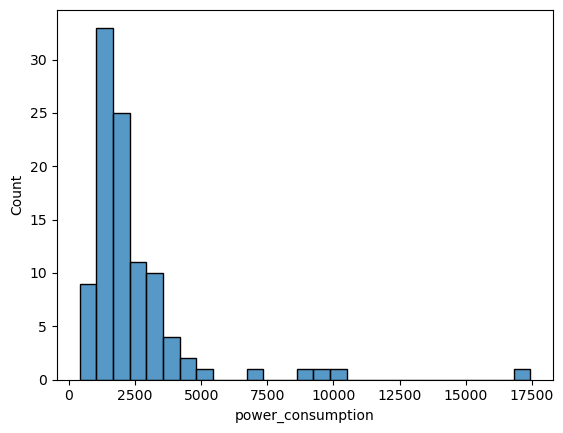

In [210]:
# 건물별 평균 전력소비량
sns.histplot(train_df.groupby('building_num')['power_consumption'].mean())

Text(0, 0.5, 'power consumption')

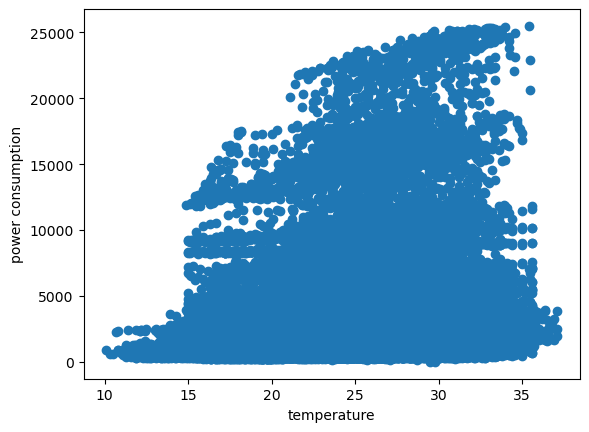

In [211]:
# 기온과 강수량 산점도
plt.scatter(train_df['temperature'], train_df['power_consumption'])
plt.xlabel('temperature')
plt.ylabel('power consumption')

In [212]:
# 태양광 장치 보유 여부와 ESS저장장치 보유 여부에 따른 전력소비량 평균 비교
print(train_df[train_df['solar'] == 0].power_consumption.mean())
print(train_df[train_df['solar'] != 0].power_consumption.mean())

print(train_df[train_df['ess'] == 0].power_consumption.mean())
print(train_df[train_df['ess'] != 0].power_consumption.mean())

# 의외로 태양광 저장 장치 보유 건물의 전력소비량 평균이 더 낮음
# ESS의 경우 보유 건물이 5개밖에 없으므로 큰 의미가 있다고 보기는 어려움

2150.2521839001224
2985.764067379262
2484.6065583591335
1813.2046302287256


## 21년 대회에 참가하신 동준이라는분 분석 방법 기반으로 분석 진행해보기

In [213]:
'''
# 각 건물별 시간과 요일에 따른 전력소비량 분석
fig = plt.figure(figsize = (40, 40))
for num in train_df['building_num'].unique():
    df = train_df[train_df.building_num == num]
    type = df.building_type.unique()[0]
    df = df.groupby(['weekday', 'hour'])['power_consumption'].mean().reset_index().pivot('weekday', 'hour', 'power_consumption')
    plt.subplot(10, 10, num)
    sns.heatmap(df)
    plt.title(f'building {num} : {type}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])
'''

"\n# 각 건물별 시간과 요일에 따른 전력소비량 분석\nfig = plt.figure(figsize = (40, 40))\nfor num in train_df['building_num'].unique():\n    df = train_df[train_df.building_num == num]\n    type = df.building_type.unique()[0]\n    df = df.groupby(['weekday', 'hour'])['power_consumption'].mean().reset_index().pivot('weekday', 'hour', 'power_consumption')\n    plt.subplot(10, 10, num)\n    sns.heatmap(df)\n    plt.title(f'building {num} : {type}')\n    plt.xlabel('')\n    plt.ylabel('')\n    plt.yticks([])\n"

### 건물별 Clustering

In [214]:
# 건물을 기준으로 하는 data frame 생성
by_weekday = train_df.groupby(['building_num','weekday'])['power_consumption'].median().reset_index().pivot('building_num','weekday','power_consumption').reset_index()
by_hour = train_df.groupby(['building_num','hour'])['power_consumption'].median().reset_index().pivot('building_num','hour','power_consumption').reset_index().drop('building_num', axis = 1)
df = pd.concat([by_weekday, by_hour], axis= 1)
columns = ['building_num'] + ['day'+str(i) for i in range(7)] + ['hour'+str(i) for i in range(24)]
df.columns = columns

In [215]:
train_df.groupby(['building_num','weekday'])['power_consumption'].median()

building_num  weekday
1             0          2388.48
              1          2585.52
              2          2455.92
              3          2484.00
              4          2599.68
                          ...   
100           2           834.48
              3           893.76
              4           921.48
              5           949.92
              6           917.76
Name: power_consumption, Length: 700, dtype: float64

In [216]:
df

building_num     day0     day1     day2      day3     day4     day5  \
0              1  2388.48  2585.52  2455.92  2484.000  2599.68  2506.08   
1              2  1219.32  1755.90  1546.38  1723.680  1517.22  1644.66   
2              3  1119.60  1290.78  1236.42  1302.120  1318.32  1271.16   
3              4   902.07   910.26   884.52   889.290   880.92   875.34   
4              5  1789.20  1822.32  1941.84  2030.760  2472.12  2739.96   
..           ...      ...      ...      ...       ...      ...      ...   
95            96  2761.92  2707.74  2728.68  2775.000  2797.68  2928.72   
96            97  1160.19  1193.49  1160.46  1221.660  1244.07  1312.56   
97            98  1170.99  1179.72  1173.15  1213.965  1249.02  1238.67   
98            99  1189.62  1144.17  1143.09  1118.970  1196.82  1222.74   
99           100   891.24   843.12   834.48   893.760   921.48   949.92   

       day6    hour0    hour1  ...   hour14   hour15   hour16   hour17  \
0   2116.80  1770.24  1714.56  ...  4336.32  4216.32  4140.96  3607.68   
1   1465.02  1239.84  1229.04  ...  2382.84  2415.24  2453.76  2292.84   
2   1255.68   959.76   908.64  ...  1692.36  1871.28  1963.08  2055.24   
3    873.63   717.66   709.20  ...  1332.54  1323.18  1299.06  1187.82   
4   2277.72  1839.60  1825.20  ...  3434.40  3309.84  2921.76  2541.60   
..      ...      ...      ...  ...      ...      ...      ...      ...   
95  2868.66  2122.56  2097.24  ...  3588.36  3624.84  3536.16  3554.76   
96  1268.55   898.56   850.50  ...  1629.18  1603.08  1596.60  1587.78   
97  1153.62   530.46   501.30  ...  1587.78  1553.40  1593.54  1625.76   
98  1234.53   750.42   694.62  ...  1523.52  1572.30  1615.68  1627.38   
99   917.76   451.44   404.40  ...  1127.76  1156.32  1169.04  1173.36   

     hour18   hour19   hour20   hour21   hour22   hour23  
0   2894.40  2733.60  2504.64  1986.72  1459.68  1867.68  
1   2354.40  2039.40  1829.16  1514.88   831.24  1289.16  
2   2524.68  2616.12  2462.04  1949.04  1150.56  1018.80  
3   1026.36   870.48   820.80   782.10   764.28   721.08  
4   2094.48  1846.08  1781.28  1724.40  1674.72  1658.88  
..      ...      ...      ...      ...      ...      ...  
95  3444.24  3323.04  3086.16  3001.92  2538.60  2323.80  
96  1549.62  1520.10  1490.40  1345.86  1164.42  1002.96  
97  1490.94  1383.12  1291.68  1130.04   855.72   663.66  
98  1530.00  1416.06  1388.16  1239.48  1006.56   855.54  
99  1119.36  1035.36   952.08   836.64   738.96   597.36  

[100 rows x 32 columns]

In [217]:
# '전력사용량'이 아닌 '요일과 시간대에 따른 전력 사용량의 경향성'에 따라서만 군집화 할 것이므로, 특수한 scaling이 필요함
# standard scaling
for i in range(len(df)):
    # 요일 별 전력 중앙값에 대해 scaling
    df.iloc[i,1:8] = (df.iloc[i,1:8] - df.iloc[i,1:8].mean())/df.iloc[i,1:8].std()
    # 시간대별 전력 중앙값에 대해 scaling
    df.iloc[i,8:] = (df.iloc[i,8:] - df.iloc[i,8:].mean())/df.iloc[i,8:].std()

In [218]:
df

building_num      day0      day1      day2      day3      day4      day5  \
0              1 -0.365033  0.842013  0.048097  0.220112  0.928756  0.355372   
1              2 -1.832654  1.112889 -0.037266  0.936019 -0.197339  0.502240   
2              3 -2.059300  0.519474 -0.299443  0.690307  0.934355  0.223904   
3              4  1.027605  1.625945 -0.254553  0.093931 -0.517560 -0.925220   
4              5 -1.021251 -0.928384 -0.593254 -0.343926  0.893631  1.644644   
..           ...       ...       ...       ...       ...       ...       ...   
95            96 -0.428483 -1.120118 -0.852808 -0.261510  0.028011  1.700802   
96            97 -1.108302 -0.520686 -1.103538 -0.023595  0.371854  1.580437   
97            98 -0.705989 -0.469207 -0.647404  0.459617  1.410409  1.129687   
98            99  0.252212 -0.784497 -0.809131 -1.359305  0.416443  1.007675   
99           100 -0.044498 -1.190415 -1.396166  0.015513  0.675630  1.352893   

        day6     hour0     hour1  ...    hour14    hour15    hour16    hour17  \
0  -2.029317 -0.903789 -0.954297  ...  1.423925  1.315072  1.246712  0.762969   
1  -0.483890 -0.930175 -0.949983  ...  1.166164  1.225588  1.296236  1.001098   
2  -0.009297 -0.865560 -0.955021  ...  0.416518  0.729634  0.890288  1.051571   
3  -1.050148 -1.006087 -1.036407  ...  1.197574  1.164029  1.077586  0.678914   
4   0.348541 -0.777633 -0.799466  ...  1.640416  1.451557  0.863147  0.286745   
..       ...       ...       ...  ...       ...       ...       ...       ...   
95  0.934106 -1.238255 -1.278298  ...  1.079826  1.137517  0.997275  1.026690   
96  0.803831 -1.225923 -1.388949  ...  1.252432  1.163898  1.141917  1.111998   
97 -1.177114 -1.474814 -1.545078  ...  1.072895  0.990053  1.086774  1.164411   
98  1.276603 -1.159134 -1.310561  ...  0.938871  1.071249  1.188971  1.220722   
99  0.587043 -1.260301 -1.413187  ...  0.937824  1.030648  1.071989  1.086030   

      hour18    hour19    hour20    hour21    hour22    hour23  
0   0.115947 -0.029916 -0.237608 -0.707418 -1.185501 -0.815400  
1   1.114004  0.536272  0.150678 -0.425733 -1.679575 -0.839719  
2   1.873108  2.033132  1.763486  0.865717 -0.531652 -0.762237  
3   0.100259 -0.458397 -0.636445 -0.775141 -0.839006 -0.993830  
4  -0.391182 -0.767808 -0.866058 -0.952300 -1.027625 -1.051642  
..       ...       ...       ...       ...       ...       ...  
95  0.851908  0.660237  0.285625  0.152404 -0.580311 -0.920005  
96  0.982555  0.882419  0.781673  0.291375 -0.324092 -0.871785  
97  0.839550  0.579748  0.359415 -0.030072 -0.691071 -1.153857  
98  0.956457  0.647251  0.571537  0.168056 -0.464032 -0.873863  
99  0.910523  0.637512  0.366842 -0.008353 -0.325825 -0.786043  

[100 rows x 32 columns]

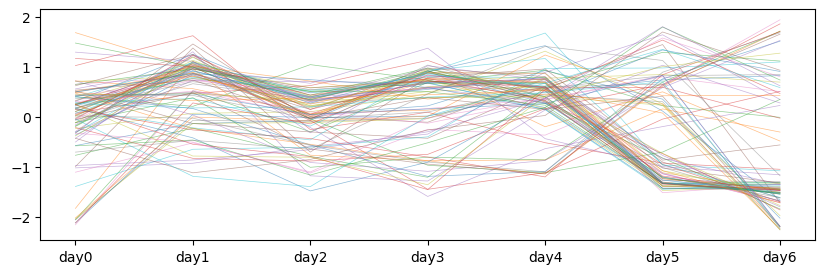

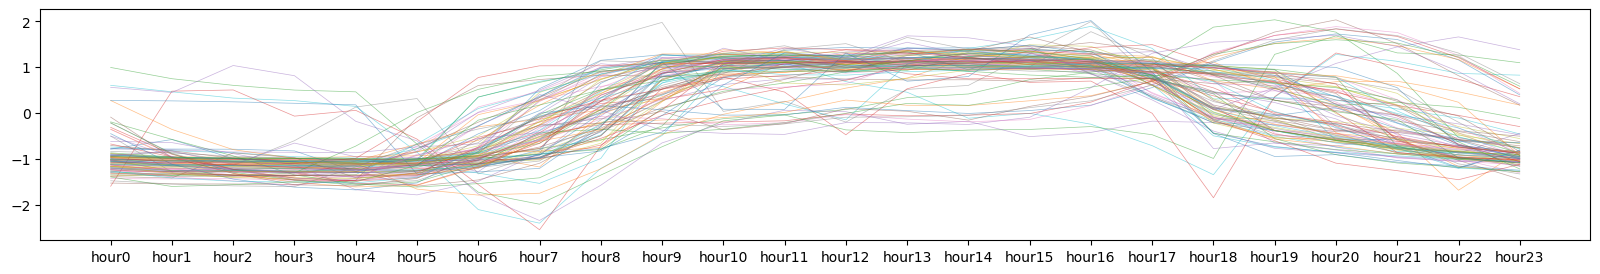

In [219]:
# visualization
fig = plt.figure(figsize = (10,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
fig = plt.figure(figsize = (20,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 8:], alpha = 0.5, linewidth = 0.5)

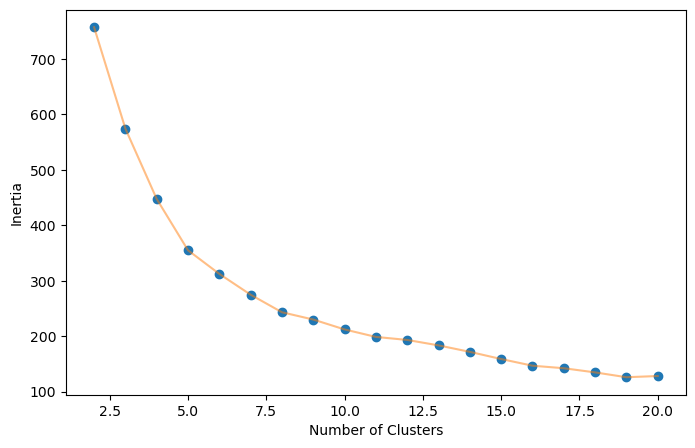

In [220]:
# k-means
# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (8, 5))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters(range(2,21), df.iloc[:,1:])

In [221]:
# 앞서 건물별로 전력소비량 확인했을 때 크게 9개의 범주로 보였었음
# elbow 기준으로는 5도 나쁘지 않아보임
# 따라서 5와9 둘 다 해보고 비교
# 추가로 6과7도 해봄
kmeans_5 = KMeans(n_clusters=5, random_state = 42)
km_cluster5 = kmeans_5.fit_predict(df.iloc[:,1:])

kmeans_9 = KMeans(n_clusters=9, random_state = 42)
km_cluster9 = kmeans_9.fit_predict(df.iloc[:,1:])

kmeans_6 = KMeans(n_clusters=6, random_state = 42)
km_cluster6 = kmeans_6.fit_predict(df.iloc[:,1:])

kmeans_7 = KMeans(n_clusters=7, random_state = 42)
km_cluster7 = kmeans_7.fit_predict(df.iloc[:,1:])

In [222]:
df_clust5 = df.copy()
df_clust5['km_cluster'] = km_cluster5

df_clust9 = df.copy()
df_clust9['km_cluster'] = km_cluster9

df_clust6 = df.copy()
df_clust6['km_cluster'] = km_cluster6

df_clust7 = df.copy()
df_clust7['km_cluster'] = km_cluster7

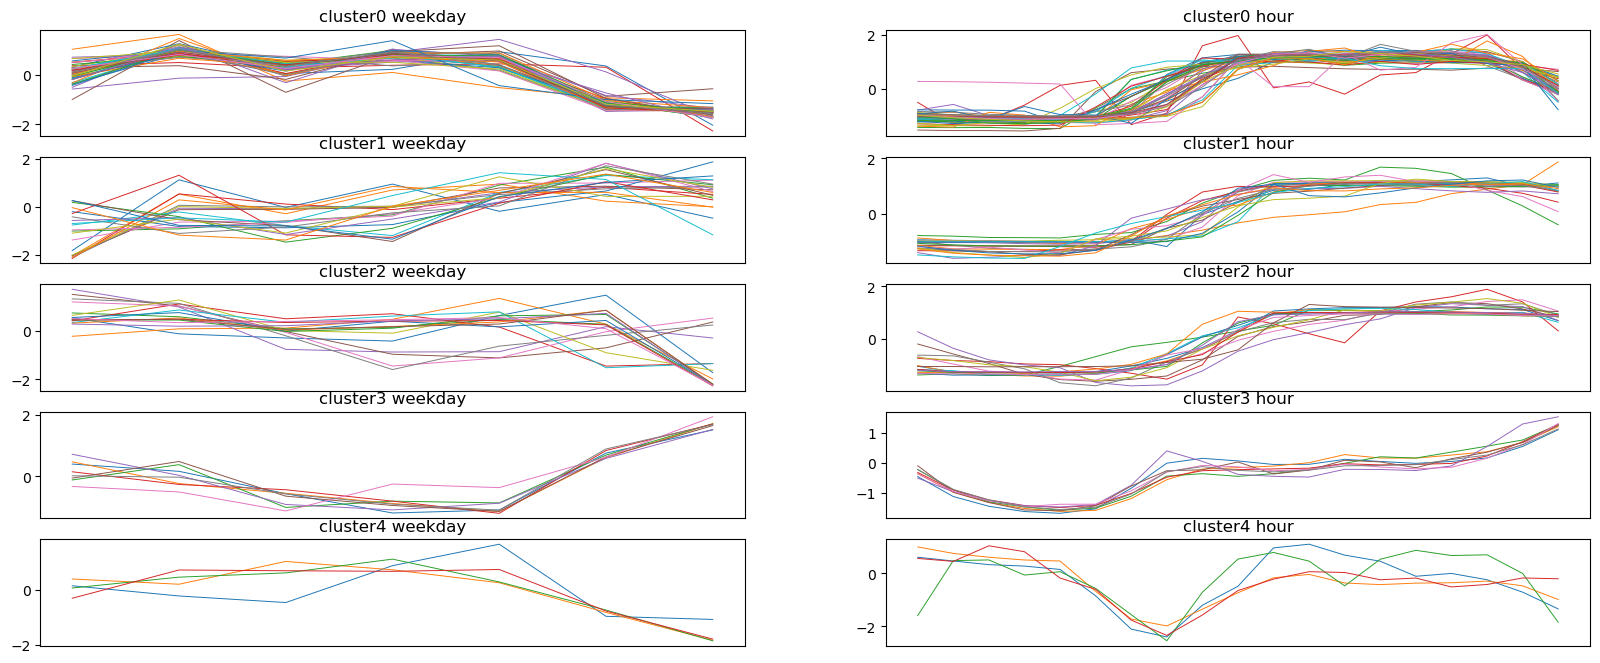

In [223]:
# visualizing result of kmeans clustering (k=5)
n_c = len(np.unique(df_clust5.km_cluster)) 

fig = plt.figure(figsize = (20,8))
for c in range(n_c):
    temp = df_clust5[df_clust5.km_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
        plt.title(f'cluster{c} weekday')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
        plt.title(f'cluster{c} hour')
        plt.xlabel('')
        plt.xticks([])

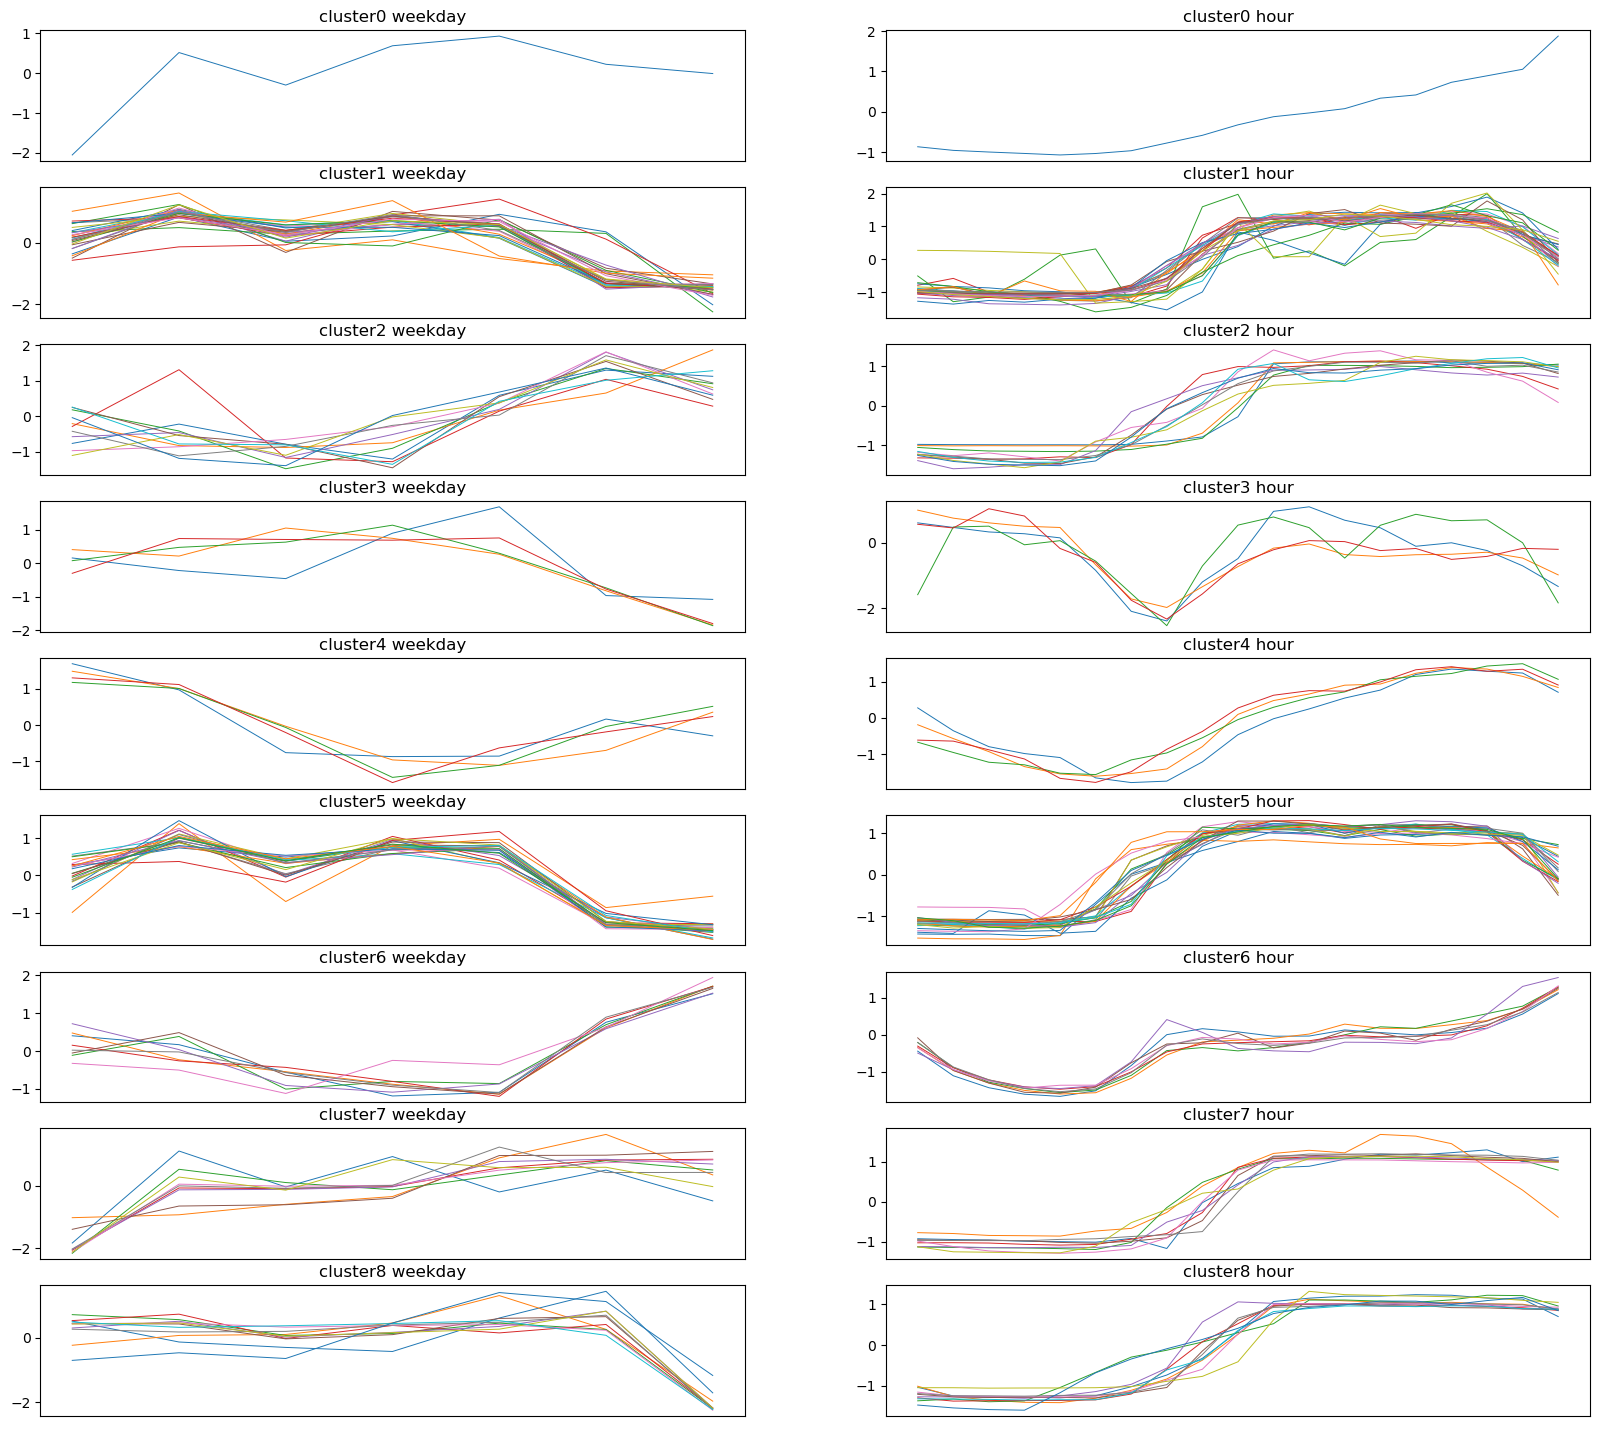

In [224]:
# visualizing result of kmeans clustering (k=9)
n_c = len(np.unique(df_clust9.km_cluster)) 

fig = plt.figure(figsize = (20,18))
for c in range(n_c):
    temp = df_clust9[df_clust9.km_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
        plt.title(f'cluster{c} weekday')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
        plt.title(f'cluster{c} hour')
        plt.xlabel('')
        plt.xticks([])

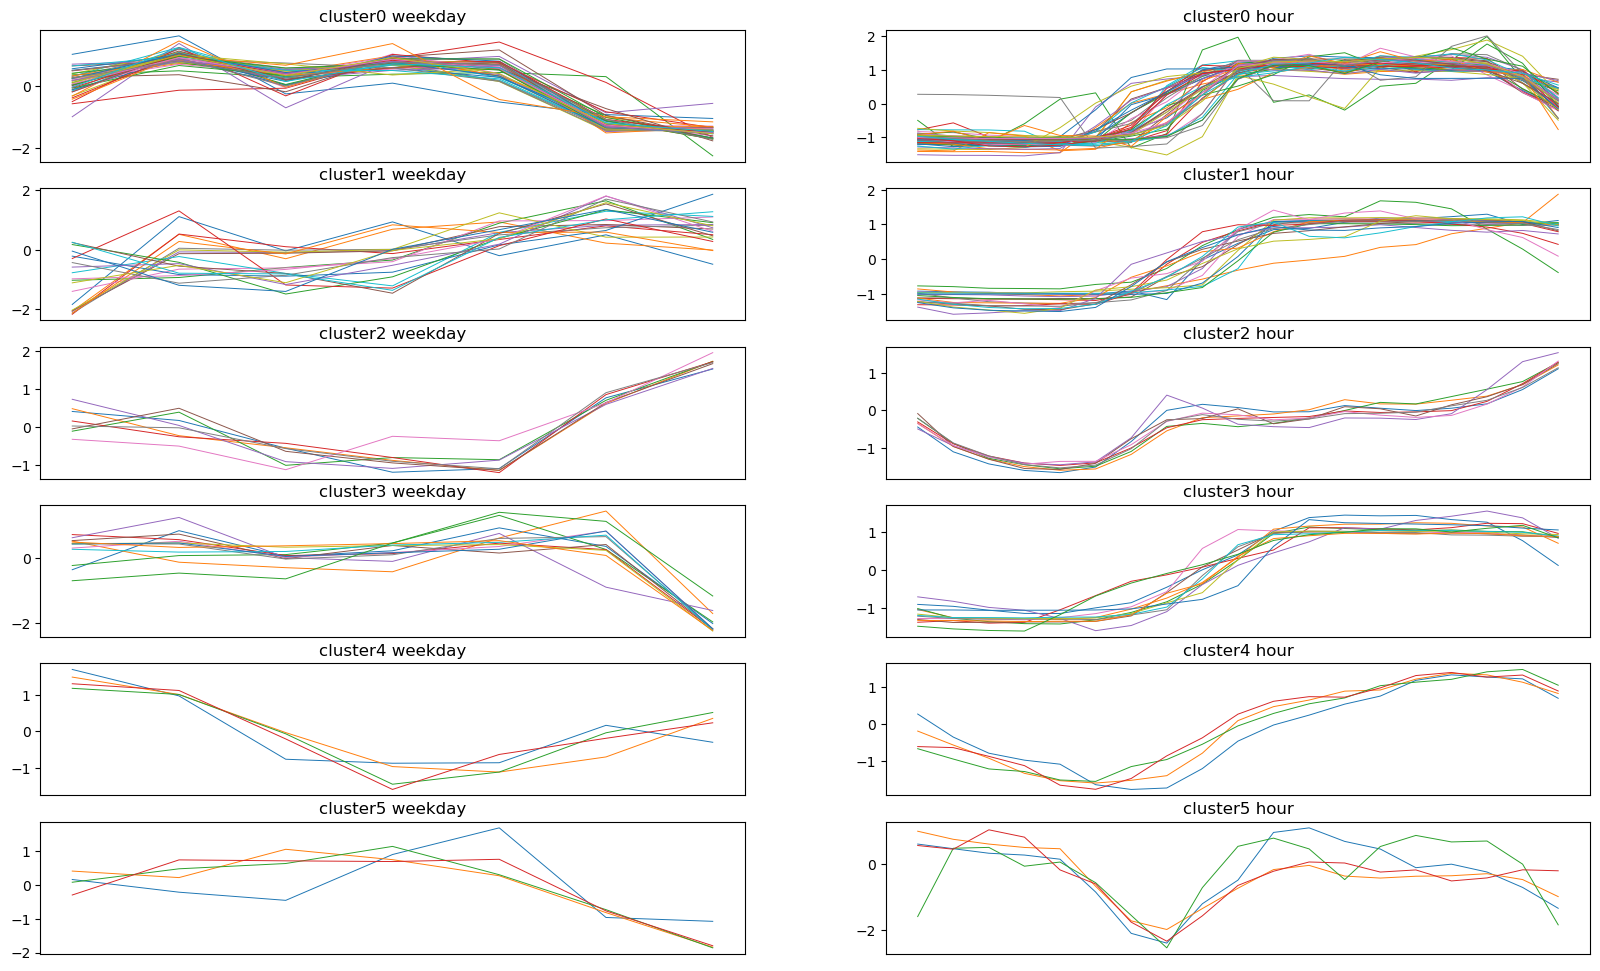

In [225]:
# visualizing result of kmeans clustering (k=6)
n_c = len(np.unique(df_clust6.km_cluster)) 

fig = plt.figure(figsize = (20,12))
for c in range(n_c):
    temp = df_clust6[df_clust6.km_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
        plt.title(f'cluster{c} weekday')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
        plt.title(f'cluster{c} hour')
        plt.xlabel('')
        plt.xticks([])

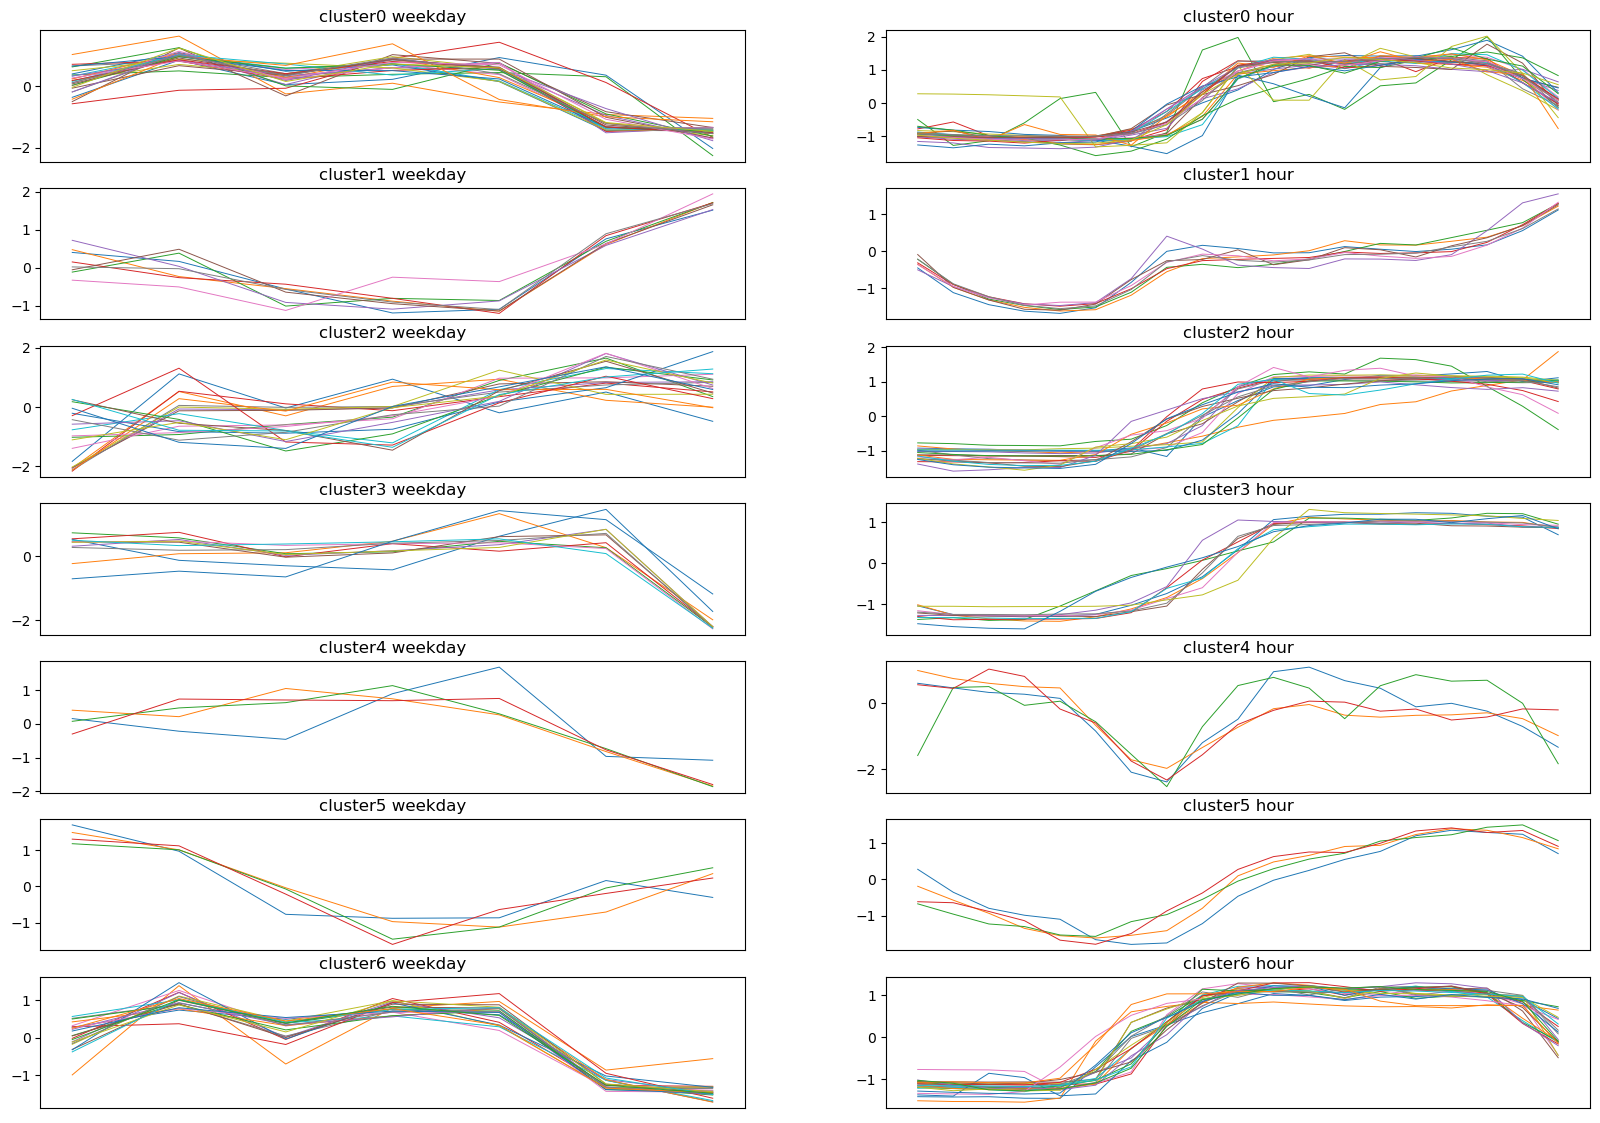

In [226]:
# visualizing result of kmeans clustering (k=7)
n_c = len(np.unique(df_clust7.km_cluster)) 

fig = plt.figure(figsize = (20,14))
for c in range(n_c):
    temp = df_clust7[df_clust7.km_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
        plt.title(f'cluster{c} weekday')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
        plt.title(f'cluster{c} hour')
        plt.xlabel('')
        plt.xticks([])

In [227]:
train_df5 = train_df.merge(df_clust5[['building_num','km_cluster']], on = 'building_num', how = 'left')
train_df9 = train_df.merge(df_clust9[['building_num','km_cluster']], on = 'building_num', how = 'left')
train_df6 = train_df.merge(df_clust6[['building_num','km_cluster']], on = 'building_num', how = 'left')
train_df7 = train_df.merge(df_clust7[['building_num','km_cluster']], on = 'building_num', how = 'left')

In [228]:
# cluster가 5개일 때 해당 클러스터에 속한 건물의 종류
for num in train_df5.km_cluster.unique():
    print(f'cluster number is {num}')
    print(train_df5[train_df5['km_cluster'] == num].building_type.unique())

cluster number is 0
['Other Buildings' 'Public' 'University' 'Hospital' 'Commercial'
 'Research Institute' 'Knowledge Industry Center']
cluster number is 1
['Other Buildings' 'Department Store and Outlet' 'Commercial'
 'Knowledge Industry Center' 'Discount Mart' 'Hotel and Resort']
cluster number is 2
['Other Buildings' 'University' 'Data Center' 'Commercial' 'Discount Mart']
cluster number is 4
['Other Buildings']
cluster number is 3
['Apartment']


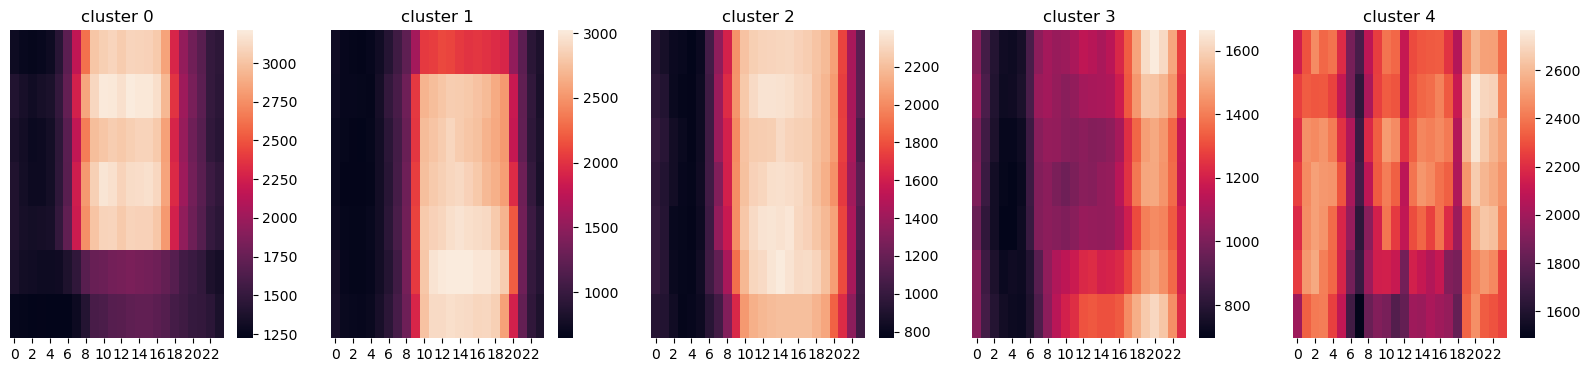

In [229]:
fig = plt.figure(figsize = (20, 4))
for c in range(5):
    temp = train_df5[train_df5.km_cluster == c]
    temp = temp.groupby(['weekday', 'hour'])['power_consumption'].median().reset_index().pivot('weekday', 'hour', 'power_consumption')
    plt.subplot(1, 5, c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

In [230]:
# cluster가 9개일 때 해당 클러스터에 속한 건물의 종류
for num in train_df9.km_cluster.unique():
    print(f'cluster number is {num}')
    print(train_df9[train_df9['km_cluster'] == num].building_type.unique())

cluster number is 1
['Other Buildings' 'University' 'Data Center' 'Hospital' 'Commercial'
 'Research Institute' 'Knowledge Industry Center']
cluster number is 7
['Other Buildings' 'Department Store and Outlet' 'Commercial']
cluster number is 0
['Other Buildings']
cluster number is 8
['Other Buildings' 'Discount Mart' 'Hotel and Resort']
cluster number is 5
['Other Buildings' 'Public' 'Hospital' 'Commercial' 'Research Institute'
 'Knowledge Industry Center']
cluster number is 3
['Other Buildings']
cluster number is 4
['Data Center']
cluster number is 2
['Department Store and Outlet' 'Knowledge Industry Center' 'Discount Mart'
 'Hotel and Resort']
cluster number is 6
['Apartment']


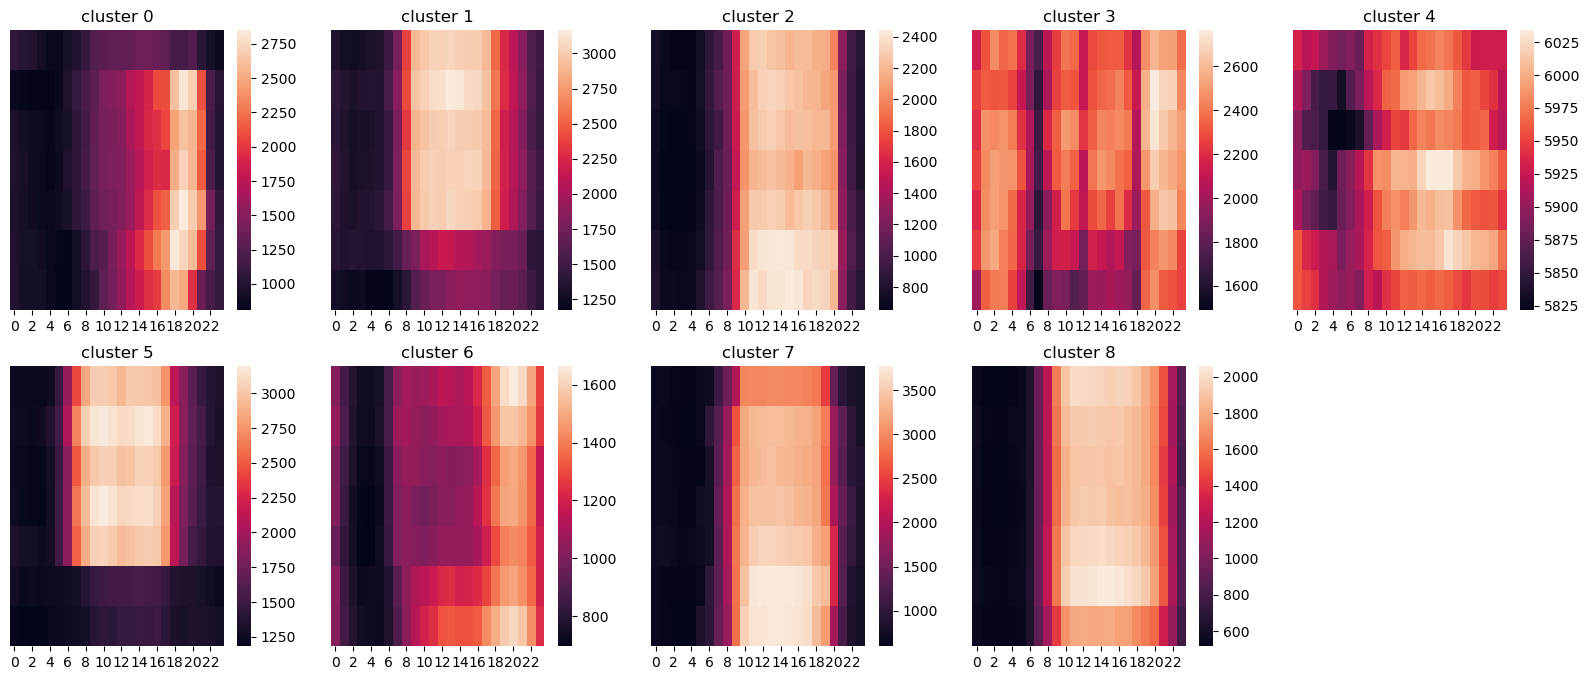

In [231]:
fig = plt.figure(figsize = (20, 8))
for c in range(9):
    temp = train_df9[train_df9.km_cluster == c]
    temp = temp.groupby(['weekday', 'hour'])['power_consumption'].median().reset_index().pivot('weekday', 'hour', 'power_consumption')
    plt.subplot(2, 5, c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

In [232]:
# cluster가 6개일 때 해당 클러스터에 속한 건물의 종류
for num in train_df6.km_cluster.unique():
    print(f'cluster number is {num}')
    print(train_df6[train_df6['km_cluster'] == num].building_type.unique())

cluster number is 3
['Other Buildings' 'Data Center' 'Discount Mart' 'Hotel and Resort']
cluster number is 1
['Other Buildings' 'Department Store and Outlet' 'Commercial'
 'Knowledge Industry Center' 'Discount Mart' 'Hotel and Resort']
cluster number is 0
['Other Buildings' 'Public' 'University' 'Hospital' 'Commercial'
 'Research Institute' 'Knowledge Industry Center']
cluster number is 5
['Other Buildings']
cluster number is 4
['Data Center']
cluster number is 2
['Apartment']


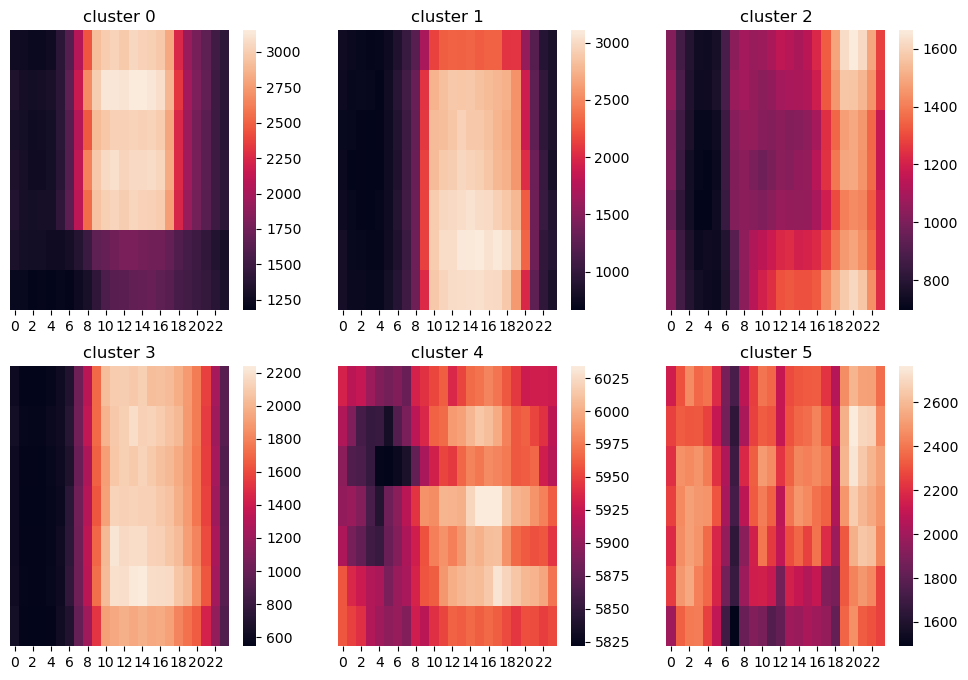

In [233]:
fig = plt.figure(figsize = (12, 8))
for c in range(6):
    temp = train_df6[train_df6.km_cluster == c]
    temp = temp.groupby(['weekday', 'hour'])['power_consumption'].median().reset_index().pivot('weekday', 'hour', 'power_consumption')
    plt.subplot(2, 3, c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

In [234]:
# cluster가 7개일 때 해당 클러스터에 속한 건물의 종류
for num in train_df7.km_cluster.unique():
    print(f'cluster number is {num}')
    print(train_df7[train_df7['km_cluster'] == num].building_type.unique())

cluster number is 0
['Other Buildings' 'University' 'Data Center' 'Hospital' 'Commercial'
 'Research Institute' 'Knowledge Industry Center']
cluster number is 2
['Other Buildings' 'Department Store and Outlet' 'Commercial'
 'Knowledge Industry Center' 'Discount Mart' 'Hotel and Resort']
cluster number is 3
['Other Buildings' 'Discount Mart' 'Hotel and Resort']
cluster number is 6
['Other Buildings' 'Public' 'Hospital' 'Commercial' 'Research Institute'
 'Knowledge Industry Center']
cluster number is 4
['Other Buildings']
cluster number is 5
['Data Center']
cluster number is 1
['Apartment']


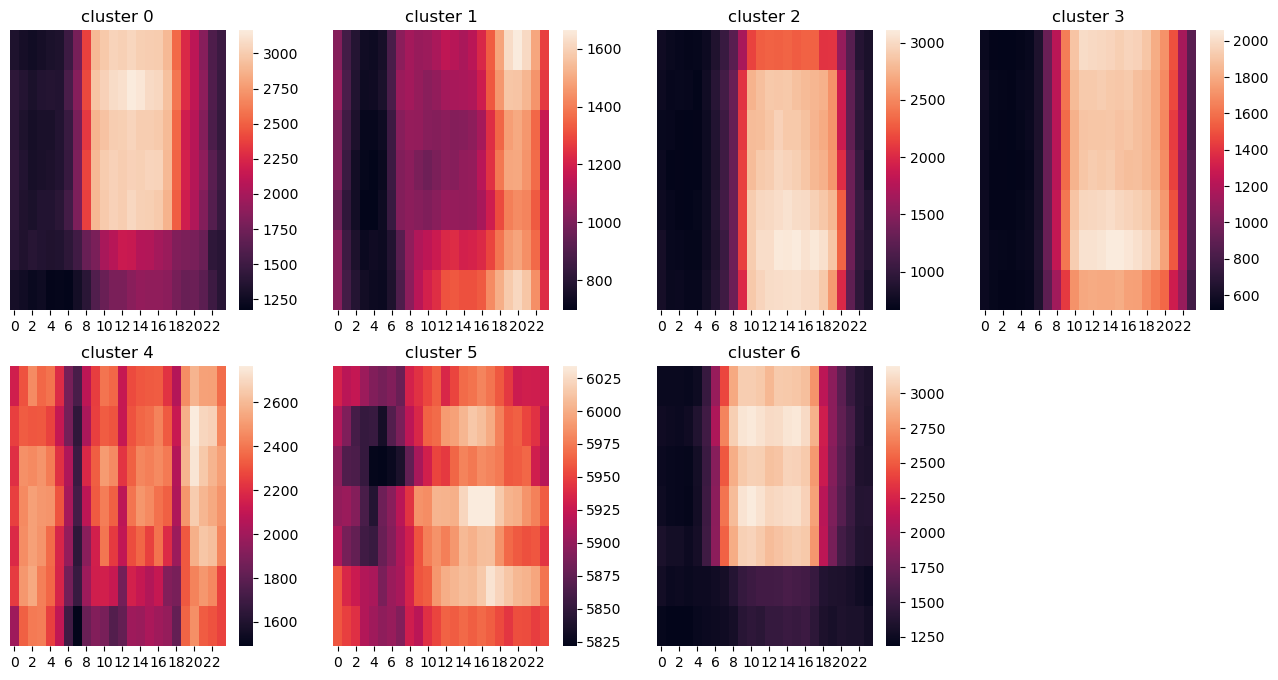

In [235]:
fig = plt.figure(figsize = (16, 8))
for c in range(7):
    temp = train_df7[train_df7.km_cluster == c]
    temp = temp.groupby(['weekday', 'hour'])['power_consumption'].median().reset_index().pivot('weekday', 'hour', 'power_consumption')
    plt.subplot(2, 4, c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

### tslearn의 TimeSeriesKMeans를 활용해서 clustering 수행

In [236]:
## 시계열 군집화용 DataFrame을 생성하는 함수 (row->num, col->date_time)
def cluster_df(train, scaler=MinMaxScaler()): # scaler=[False, 'MinMaxScaler()', 'StandardScaler()']
    train_ = train.copy()
    train_ts = train_.pivot_table(values='power_consumption', index=train_.building_num, columns='date', aggfunc='first')
    
    if scaler:
        train_ts_T = scaler.fit_transform(train_ts.T)
        train_ts = pd.DataFrame(train_ts_T.T, index=train_ts.index, columns=train_ts.columns)
    
    return train_ts

In [237]:
## 여러 n_clueter에 대해 TimeSeriesKmeans를 시행하고 이를 시각화하는 함수
def visualize_n_cluster(train_ts, n_lists, metric='dtw', seed=42, vis=True):

    if vis:
        fig = plt.figure(figsize = (20 ,5))
        plt.title("Distribution of number of buildings by number of clusters", fontsize=15, y=1.2)
        plt.axis('off')
    
    for idx, n in enumerate(n_lists):
        ts_kmeans = TimeSeriesKMeans(n_clusters=n, metric=metric, random_state=seed)
        train_ts['cluster(n={})'.format(n)] = ts_kmeans.fit_predict(train_ts)
        score = round(silhouette_score(train_ts, train_ts['cluster(n={})'.format(n)], metric='euclidean'),3)
        
        vc = train_ts['cluster(n={})'.format(n)].value_counts()
        
        if vis:
            ax = fig.add_subplot(1,len(n_lists), idx+1)
            sns.barplot(x=vc.index, y=vc, palette='Pastel1')
            ax.set(title='n_cluster={0}\nscore: {1}'.format(n,score))
    if vis: 
        plt.tight_layout()
        plt.show()
    
    return train_ts

In [238]:
## 클러스터 별 시간&요일별 전력사용량 평균 시각화
def visualize_by_cluster(df_with_labels, n_cluster, algorithm):
    fig = plt.figure(figsize = (20 ,4*n_cluster))
    plt.title('Time series distribution for each cluster when there are {}'.format(n_cluster), fontsize=15, y=1.05)
    plt.axis('off')
    
    if algorithm=='kmeans':
        labels = df_with_labels['cluster(n={})'.format(n_cluster)]
    elif algorithm=='som':
        labels = df_with_labels.cluster
        
    idx=1
    for label in set(labels): # 각 군집에 대해
        
        if algorithm=='kmeans':
            df = train_df[train_df.building_num.isin(list(labels[labels==label].keys()))]
        elif algorithm=='som':
            df = train_df[train_df.building_num.isin(som_df[som_df.cluster==label].building_num.values)]
        
        hour = df.hour.unique()
        weekday = df.weekday.unique()
        
        ### x축: 시간 ###
        ax = fig.add_subplot(n_cluster,2, idx); idx+=1
        ax.set(title='Average hourly power usage for cluster {}'.format(label))
        ax.set_xticks(hour)
        for building_num in df.building_num.unique():
            df_one = df[df.building_num==building_num]
            sns.lineplot(x=hour, y=df_one.groupby('hour')['power_consumption'].mean(), color='grey', alpha=0.3)
        sns.lineplot(x=hour, y=df.groupby('hour')['power_consumption'].mean(), color='red')
        
        ### x축: 요일 ###
        ax = fig.add_subplot(n_cluster,2, idx); idx+=1
        ax.set(title='Average power usage by day of the week for cluster {}'.format(label))
        for building_num in df.building_num.unique():
            df_one = df[df.building_num==building_num]
            df_one_counts = df_one.groupby('weekday')['power_consumption'].mean()
            df_one_counts = df_one_counts.reindex(weekday)
            sns.lineplot(x=weekday, y=df_one_counts, color='grey', alpha=0.3)
        df_counts = df.groupby('weekday')['power_consumption'].mean()
        df_counts = df_counts.reindex(weekday)
        sns.pointplot(x=weekday, y=df_counts, color='red')
        ax.legend(['a total of {} buildings'.format(df.building_num.nunique())], loc=1)

    plt.show()

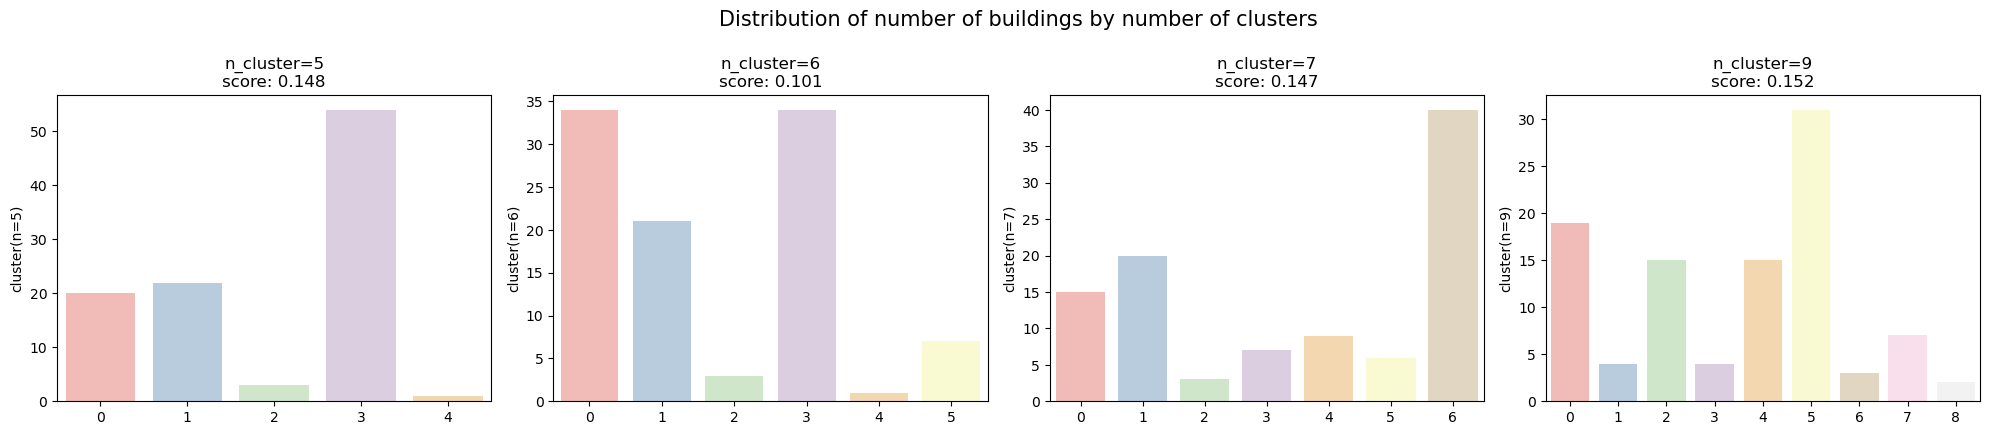

In [245]:
train_ts = cluster_df(train_df, scaler=StandardScaler())
train_ts = visualize_n_cluster(train_ts, n_lists=[5,6,7,9], metric='euclidean', seed=42, vis=True)

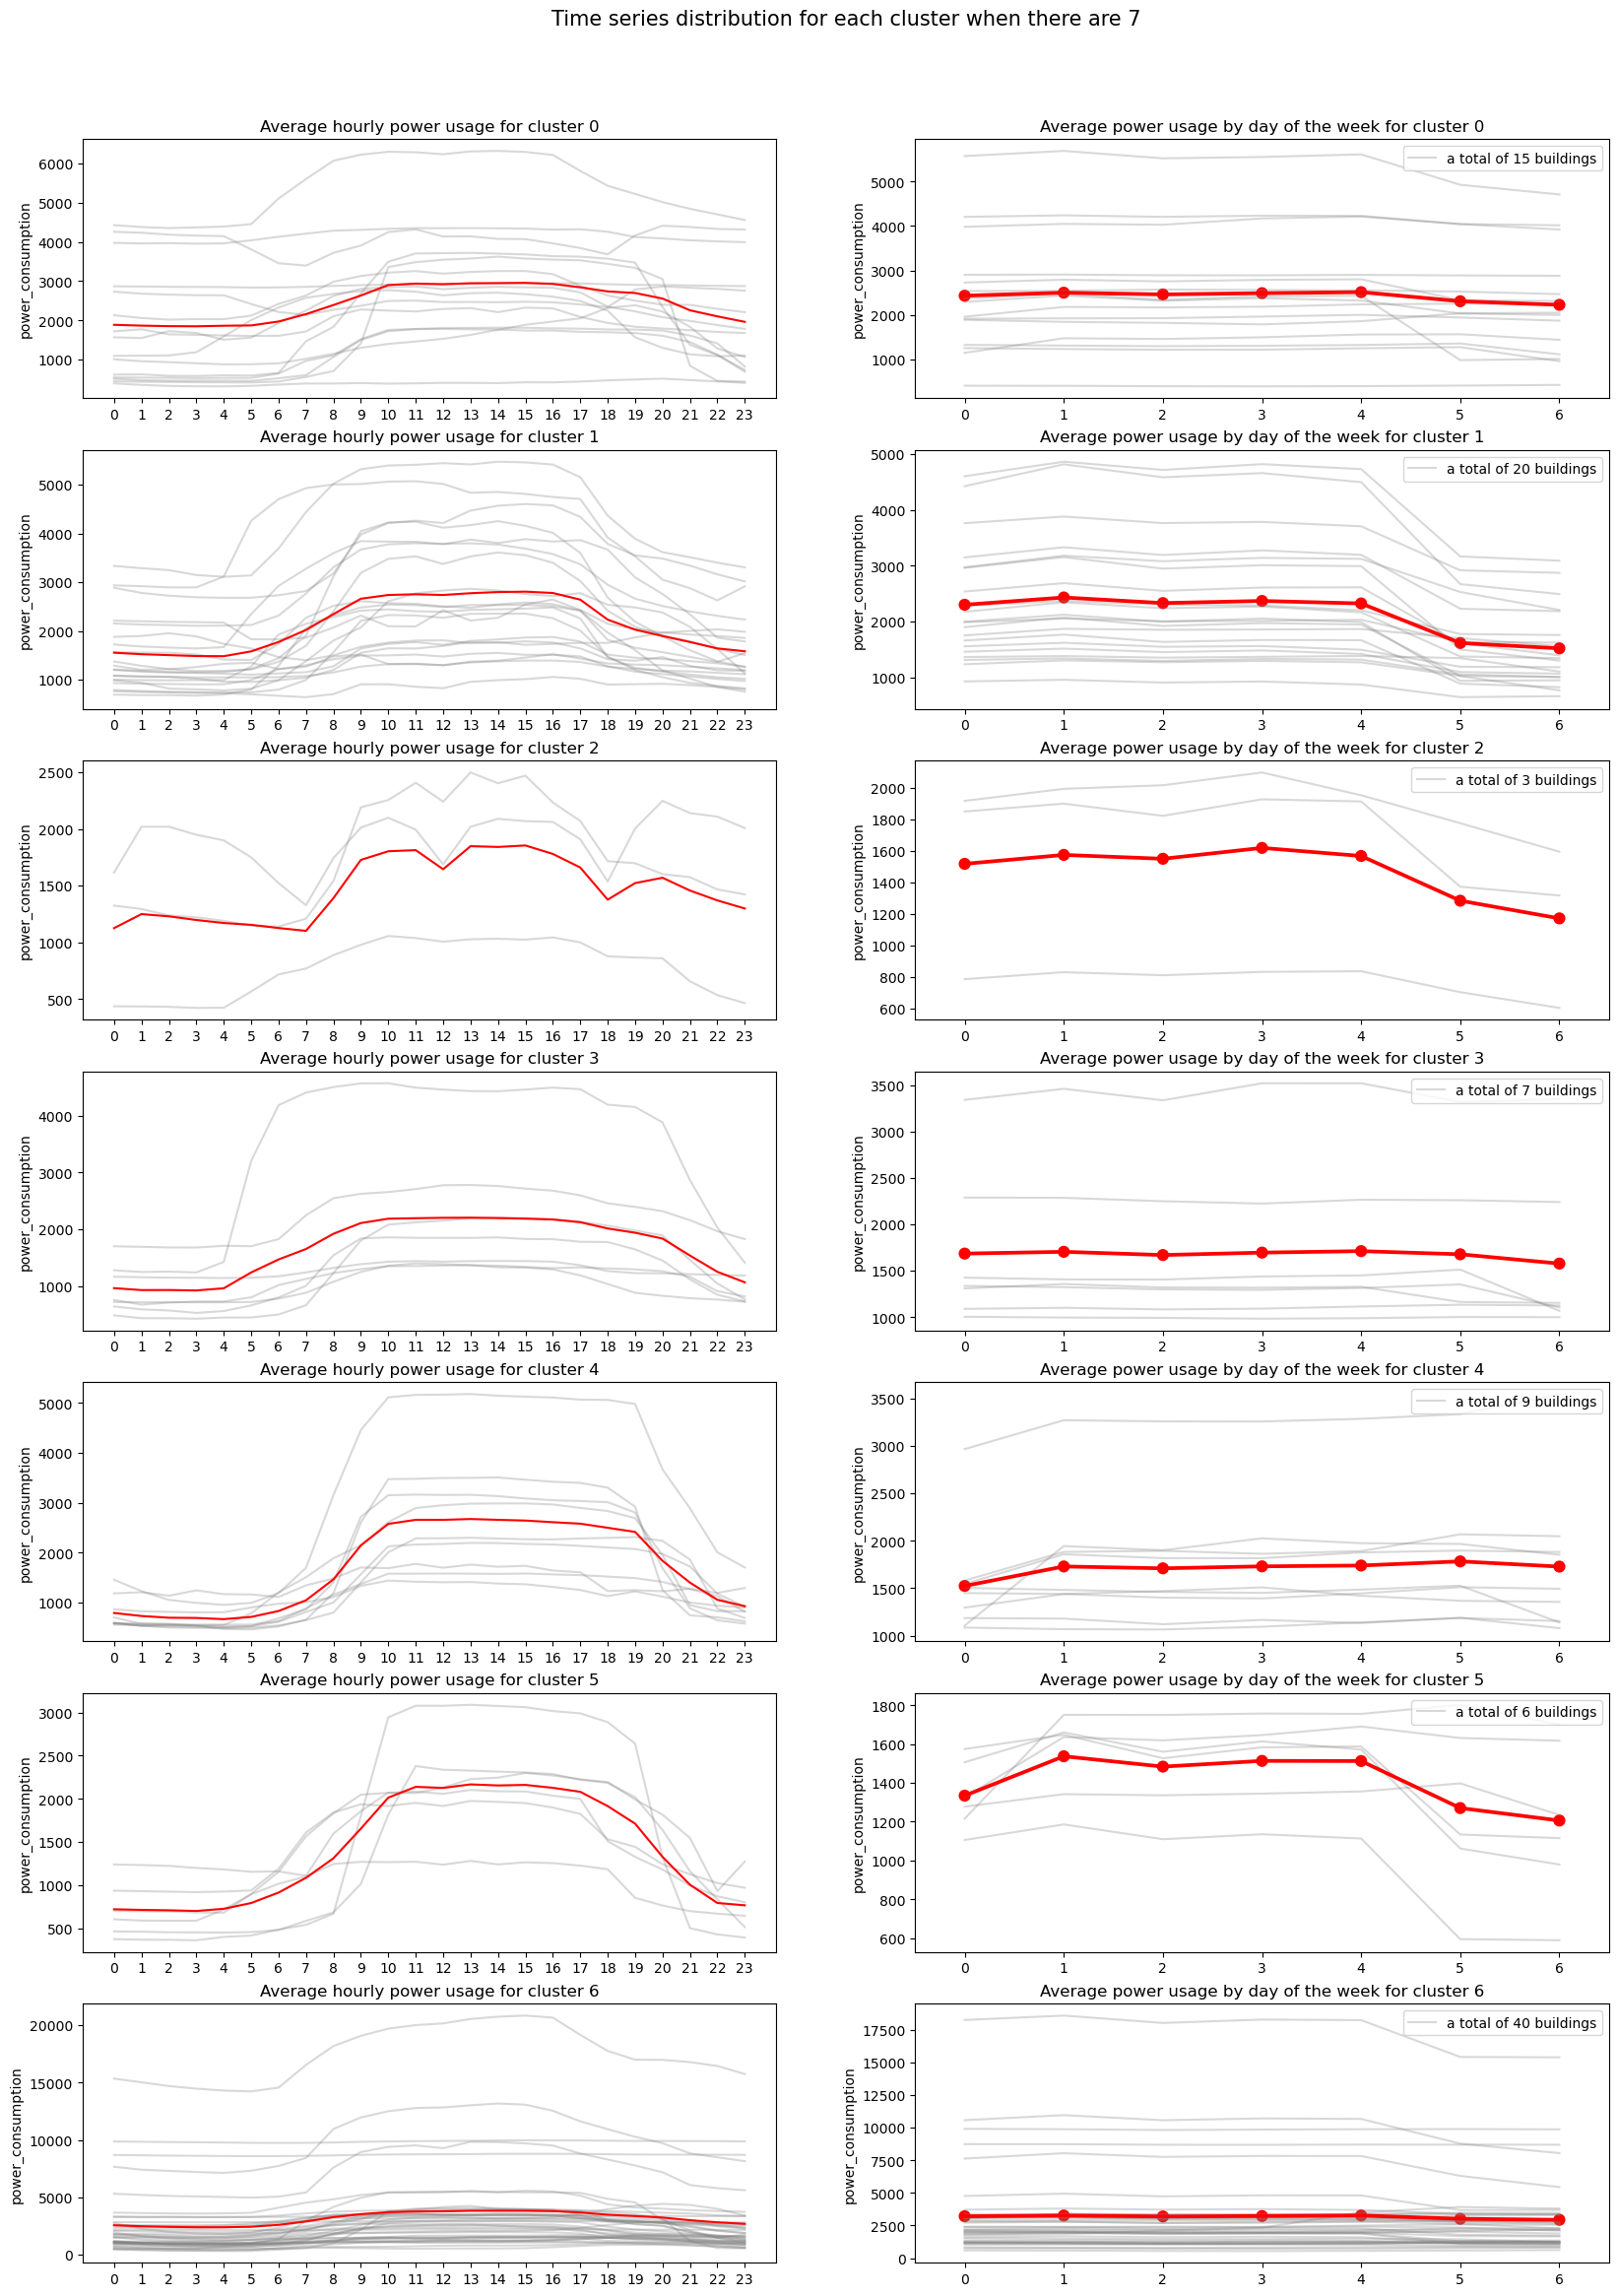

In [247]:
# n=7
visualize_by_cluster(train_ts, n_cluster=7, algorithm='kmeans')

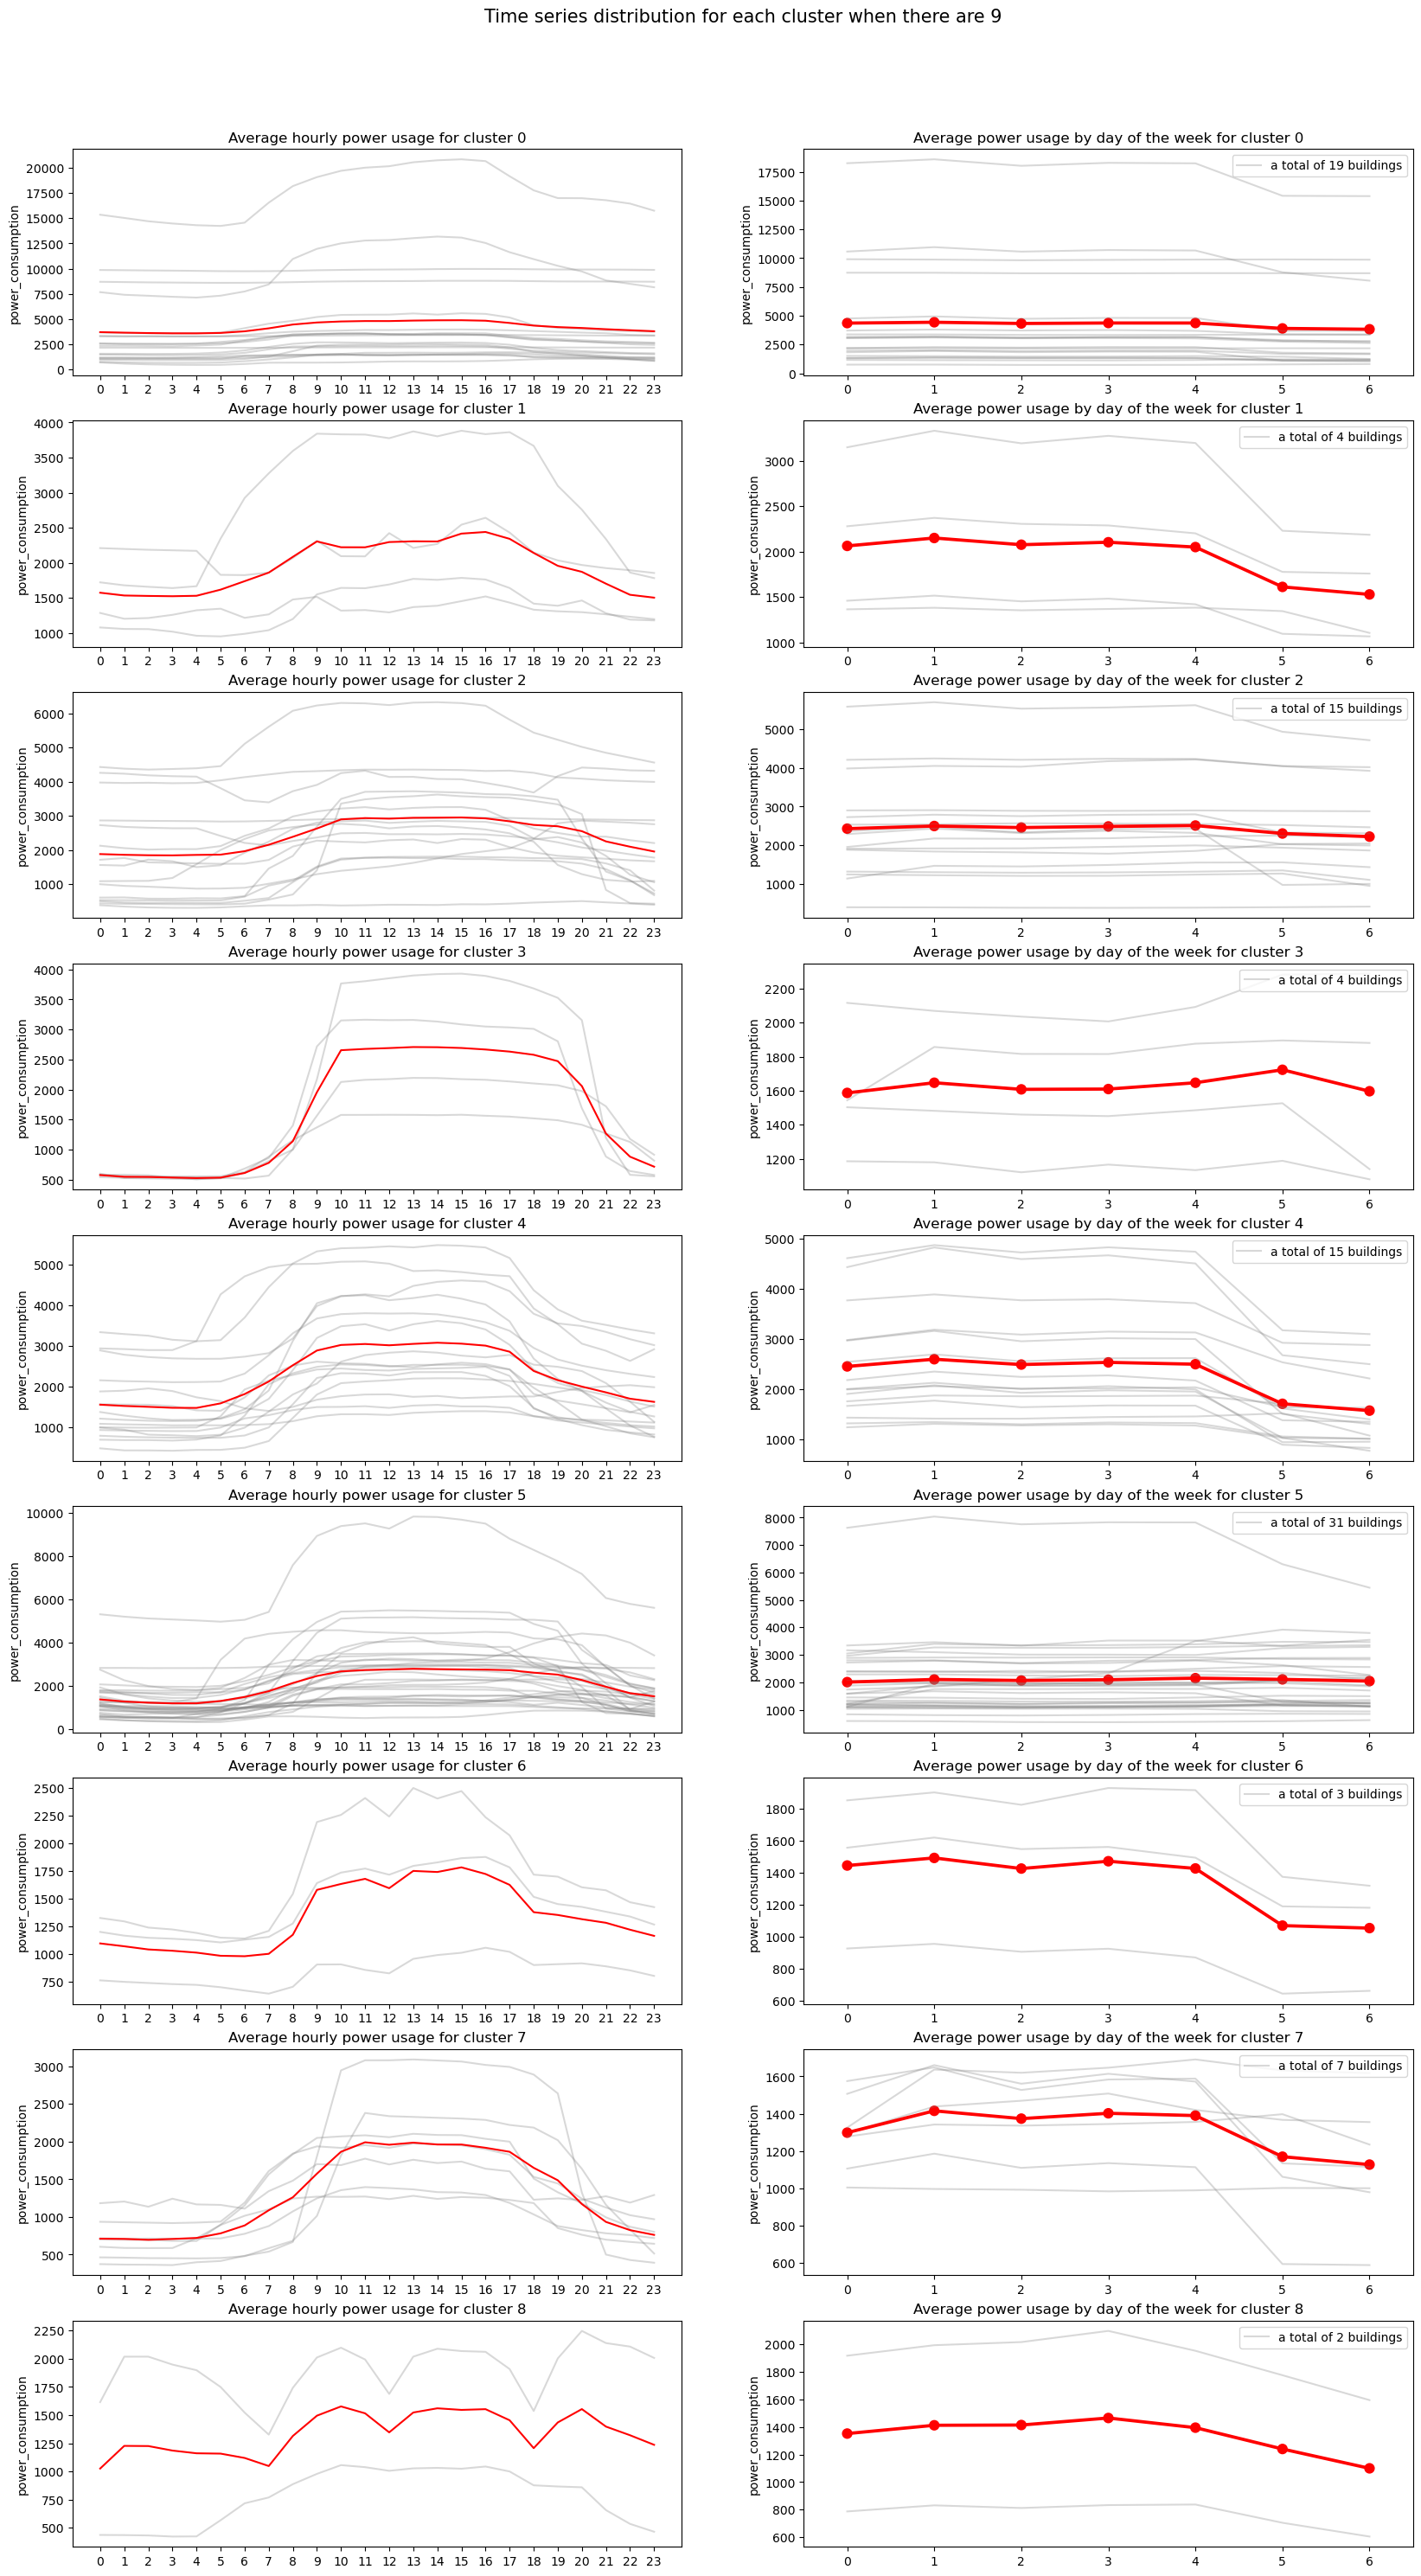

In [241]:
# n=9
visualize_by_cluster(train_ts, n_cluster=9, algorithm='kmeans')

### TimeSeriesKMeans를 이용해서 위에서 시각화 했던 거 다시 해보기

In [289]:
tkmeans_5 = TimeSeriesKMeans(n_clusters=5, random_state = 42)
tkm_cluster5 = tkmeans_5.fit_predict(df.iloc[:,1:])

tkmeans_6 = TimeSeriesKMeans(n_clusters=6, random_state = 42)
tkm_cluster6 = tkmeans_6.fit_predict(df.iloc[:,1:])

tkmeans_7 = TimeSeriesKMeans(n_clusters=7, random_state = 42)
tkm_cluster7 = tkmeans_7.fit_predict(df.iloc[:,1:])

tkmeans_9 = TimeSeriesKMeans(n_clusters=9, random_state = 42)
tkm_cluster9 = tkmeans_9.fit_predict(df.iloc[:,1:])

In [292]:
tdf_clust5 = df.copy()
tdf_clust5['km_cluster'] = tkm_cluster5

tdf_clust9 = df.copy()
tdf_clust9['km_cluster'] = tkm_cluster9

tdf_clust6 = df.copy()
tdf_clust6['km_cluster'] = tkm_cluster6

tdf_clust7 = df.copy()
tdf_clust7['km_cluster'] = tkm_cluster7

In [293]:
ttrain_df5 = train_df.merge(tdf_clust5[['building_num','km_cluster']], on = 'building_num', how = 'left')
ttrain_df9 = train_df.merge(tdf_clust9[['building_num','km_cluster']], on = 'building_num', how = 'left')
ttrain_df6 = train_df.merge(tdf_clust6[['building_num','km_cluster']], on = 'building_num', how = 'left')
ttrain_df7 = train_df.merge(tdf_clust7[['building_num','km_cluster']], on = 'building_num', how = 'left')

In [296]:
# 클러스터 개수에 따른 건물의 종류
print('number of cluster : 5')
for num in ttrain_df5.km_cluster.unique():
    print(f'cluster number is {num}')
    print(ttrain_df5[ttrain_df5['km_cluster'] == num].building_type.unique())

print('\nnumber of cluster : 6')
for num in ttrain_df6.km_cluster.unique():
    print(f'cluster number is {num}')
    print(ttrain_df6[ttrain_df6['km_cluster'] == num].building_type.unique())

print('\nnumber of cluster : 7')
for num in ttrain_df7.km_cluster.unique():
    print(f'cluster number is {num}')
    print(ttrain_df7[ttrain_df7['km_cluster'] == num].building_type.unique())

print('\nnumber of cluster : 9')
for num in ttrain_df9.km_cluster.unique():
    print(f'cluster number is {num}')
    print(ttrain_df9[ttrain_df9['km_cluster'] == num].building_type.unique())

number of cluster : 5
cluster number is 0
['Other Buildings' 'Public' 'University' 'Hospital' 'Commercial'
 'Research Institute' 'Knowledge Industry Center']
cluster number is 1
['Other Buildings' 'Department Store and Outlet' 'Commercial'
 'Knowledge Industry Center' 'Discount Mart' 'Hotel and Resort']
cluster number is 2
['Other Buildings' 'University' 'Data Center' 'Commercial' 'Discount Mart']
cluster number is 4
['Other Buildings']
cluster number is 3
['Apartment']

number of cluster : 6
cluster number is 0
['Other Buildings' 'Public' 'University' 'Hospital' 'Commercial'
 'Research Institute' 'Knowledge Industry Center']
cluster number is 1
['Other Buildings' 'Department Store and Outlet' 'Commercial'
 'Knowledge Industry Center' 'Discount Mart' 'Hotel and Resort']
cluster number is 2
['Other Buildings' 'University' 'Data Center' 'Discount Mart']
cluster number is 5
['Other Buildings']
cluster number is 3
['Apartment']
cluster number is 4
['Research Institute']

number of cluster 

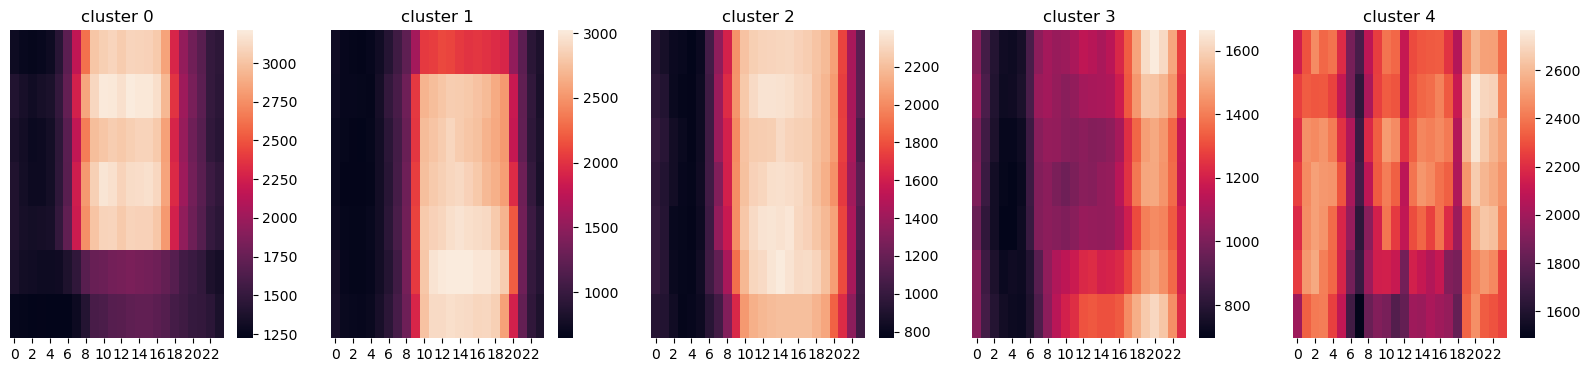

In [297]:
fig = plt.figure(figsize = (20, 4))
for c in range(5):
    temp = ttrain_df5[ttrain_df5.km_cluster == c]
    temp = temp.groupby(['weekday', 'hour'])['power_consumption'].median().reset_index().pivot('weekday', 'hour', 'power_consumption')
    plt.subplot(1, 5, c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

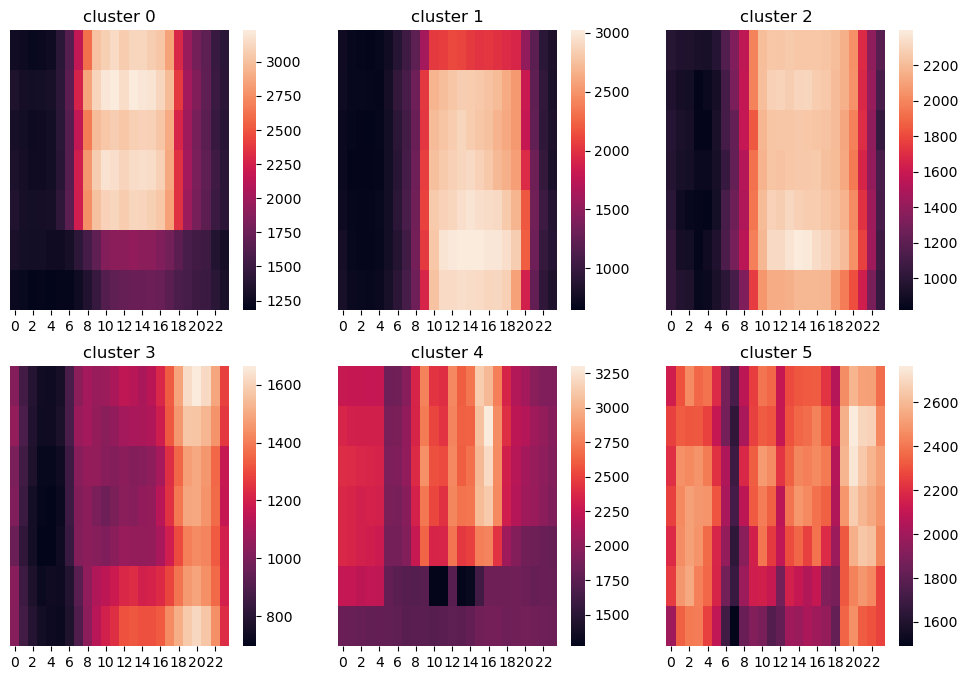

In [298]:
fig = plt.figure(figsize = (12, 8))
for c in range(6):
    temp = ttrain_df6[ttrain_df6.km_cluster == c]
    temp = temp.groupby(['weekday', 'hour'])['power_consumption'].median().reset_index().pivot('weekday', 'hour', 'power_consumption')
    plt.subplot(2, 3, c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

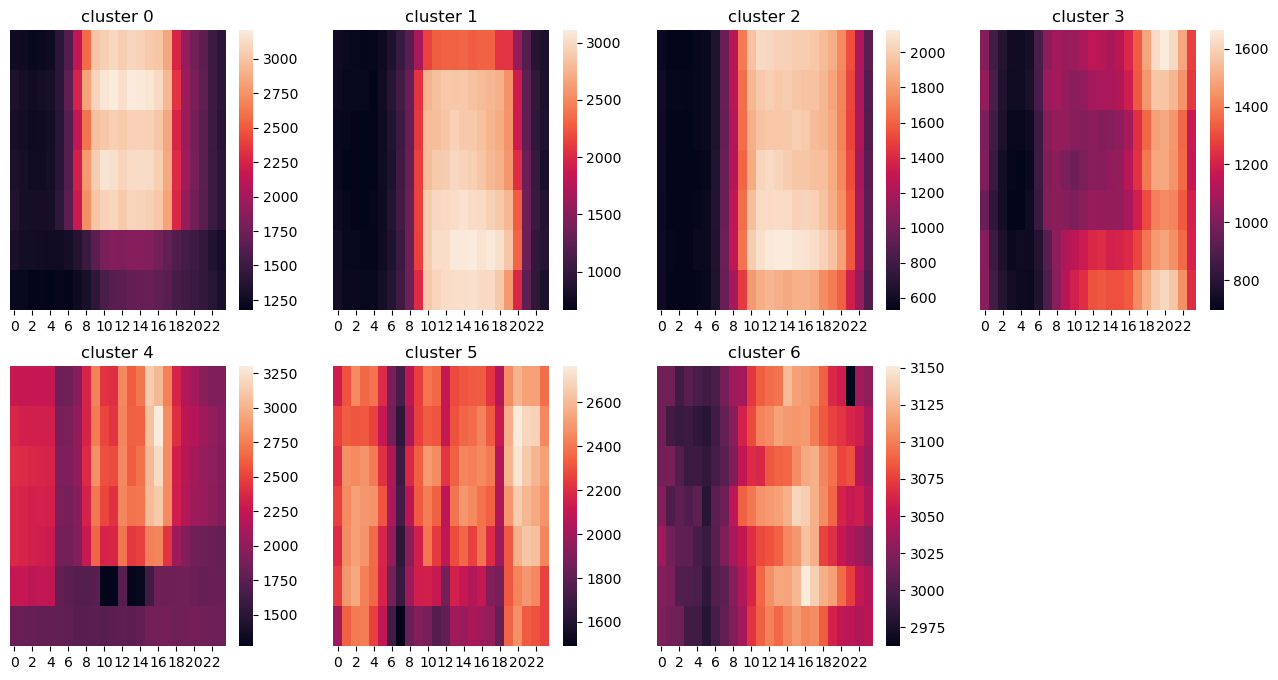

In [300]:
fig = plt.figure(figsize = (16, 8))
for c in range(7):
    temp = ttrain_df7[ttrain_df7.km_cluster == c]
    temp = temp.groupby(['weekday', 'hour'])['power_consumption'].median().reset_index().pivot('weekday', 'hour', 'power_consumption')
    plt.subplot(2, 4, c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

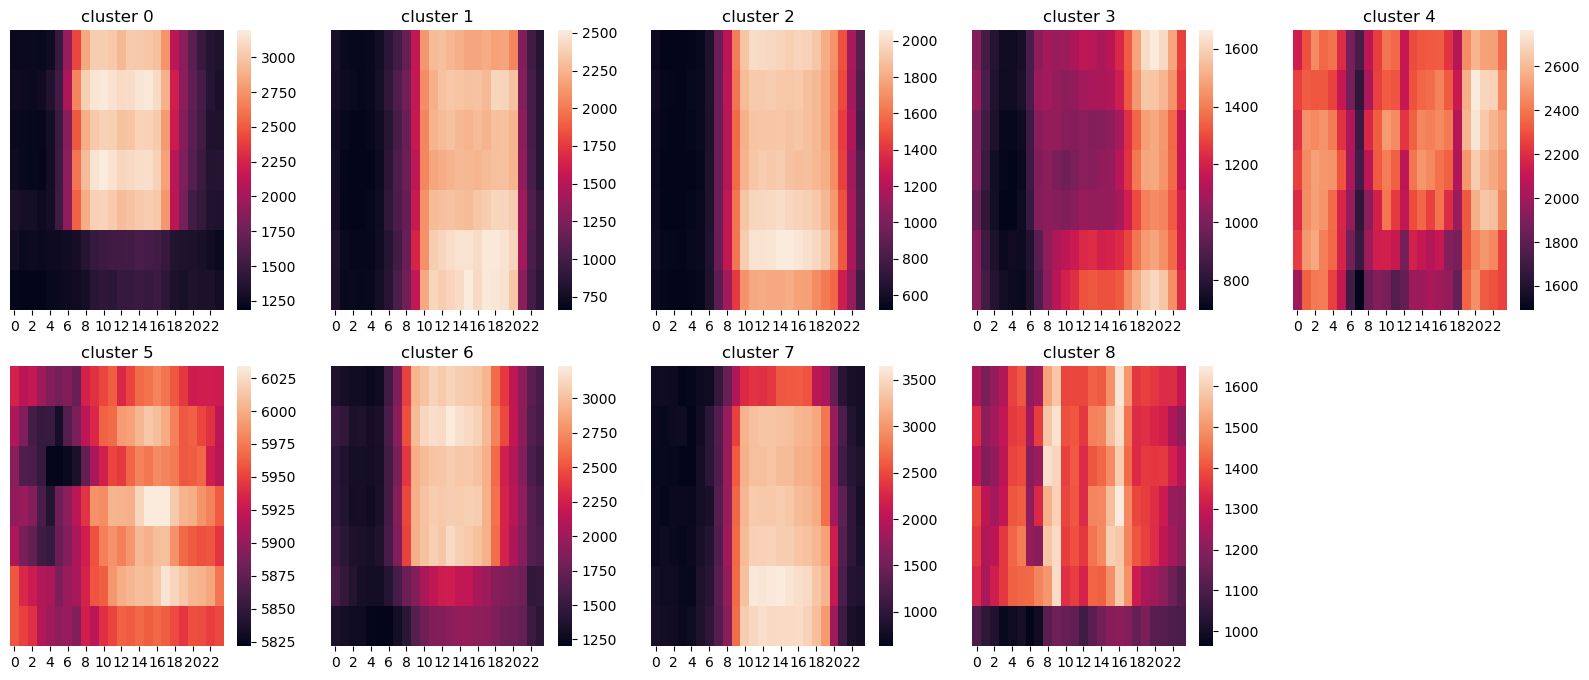

In [299]:
fig = plt.figure(figsize = (20, 8))
for c in range(9):
    temp = ttrain_df9[ttrain_df9.km_cluster == c]
    temp = temp.groupby(['weekday', 'hour'])['power_consumption'].median().reset_index().pivot('weekday', 'hour', 'power_consumption')
    plt.subplot(2, 5, c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

## Time series elements analysis

- date
- month
- day
- weekday
- hour
- weekend

## Non-time series elements analysis

- building_num
- temperature
- precipitation
- windspeed
- humidity
- building_type
- total_area
- cooling_area
- solar
- ess
- pcs